<a href="https://colab.research.google.com/github/Vaxx66/dipha/blob/master/DataSpace_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix


# 1. Dataset

The dataset analyzed is AVILA and it is available on UCI (https://archive.ics.uci.edu/ml/datasets/Avila).
It is already divided in training and test set, respectively with 10430 and 10437 samples; each sample represents a group of 4 consecutive rows of the "Avila Bible" and it is characterized by 10 features.

"Avila Bible" is a Latin copy of the Bible dating XII century and produced between Italy and Spain hypothetically by 12 copyists at which different samples of the dataset are associated, not in equal number. 

The data in the dataset have been already normalized through Z-normalization method.

Each copyist is identified by an alphabetic letter in the set: [A, B, C, D, E, F, G, H, I, W, X, Y] and each samples is represented by the following attributes:
  
* intercolumnar distance (F1)
* upper margin (F2)
* lower margin (F3)
* exploitation (F4)
* row number (F5)
* modular ratio (F6)
* interlinear spacing (F7)
* weight (F8)
* peak number (F9)
* modular ratio/ interlinear spacing (F10)
* Class:  (A, B, C, D, E, F, G, H, I, W, X, Y)

In [0]:
names = ['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','class']

train_data = pd.read_csv('/Users/giuseppe.pastore/Documents/Data spaces/Dataset/avila/avila-tr.csv',header=None,names=names)
X_train = train_data.iloc [:, [0,1,2,3,4,5,6,7,8,9]] 
Y_train = train_data.iloc [:, [10]] 

test_data =  pd.read_csv('/Users/giuseppe.pastore/Documents/Data spaces/Dataset/avila/avila-ts.csv',header=None,names=names)
X_test = test_data.iloc [:, [0,1,2,3,4,5,6,7,8,9]] 
Y_test = test_data.iloc [:, [10]] 

#### Class distribution of the training data
The histogram shows the class distribution of the training set: *A* is the copyist to which more pattern are associated (*4286*) while B is the one with the smallest number (*5*).

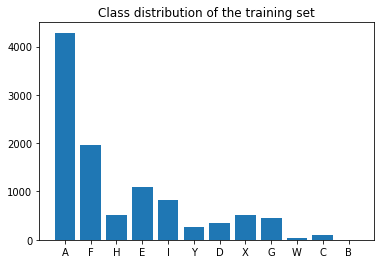

In [0]:
list = Y_train.values.tolist()
flat_list = [item for sublist in list for item in sublist]

counts = Counter(flat_list)

labels, values = zip(*counts.items())

indexes = np.arange(len(labels))


plt.bar(indexes, values, align='center')
plt.title("Class distribution of the training set")
# add labels
plt.xticks(indexes, labels)
plt.show()


#### Descriptive statistics of training dataset

Below the general descriptive statistics of the training set are reported per feature:

* *count* is the number of non null observations and it is equal to the dataset's size;
* *mean* is the mean of the values and are near to 0 for all the features because of the Z-normalization;
* *std* is the standard deviation of the observations;
* *min* is the minimum value among the observations;
* *25%* is the first quartile;
* *50%* is the second quartile or median;
* *75%* is the third quartile;
* *max* is the maximum value among the observations;

In [0]:
pd.options.display.float_format = "{:.3f}".format 
print(X_train.describe(include="all"))

             F1        F2        F3        F4        F5        F6        F7  \
count 10430.000 10430.000 10430.000 10430.000 10430.000 10430.000 10430.000   
mean      0.001     0.034    -0.001    -0.002     0.006     0.014     0.006   
std       0.991     3.921     1.120     1.009     0.992     1.126     1.314   
min      -3.499    -2.427    -3.211    -5.440    -4.922    -7.450   -11.935   
25%      -0.129    -0.260     0.065    -0.528     0.172    -0.599    -0.044   
50%       0.044    -0.056     0.218     0.096     0.262    -0.059     0.220   
75%       0.204     0.203     0.353     0.658     0.262     0.564     0.447   
max      11.820   386.000    50.000     3.987     1.066    53.000    83.000   

             F8        F9       F10  
count 10430.000 10430.000 10430.000  
mean      0.010     0.013     0.001  
std       1.004     1.088     1.007  
min      -4.248    -5.486    -6.719  
25%      -0.542    -0.372    -0.516  
50%       0.112     0.064    -0.035  
75%       0.655     0.

#### Features distribution 

A graphical view of features distribution is reported in the plot below: where it is possible to see a smooth and similar 0-centered shape for almost all the features, with the excpetion of 'Row number' (*F5*) for which a strange peaks reveal the presence of anomalies.

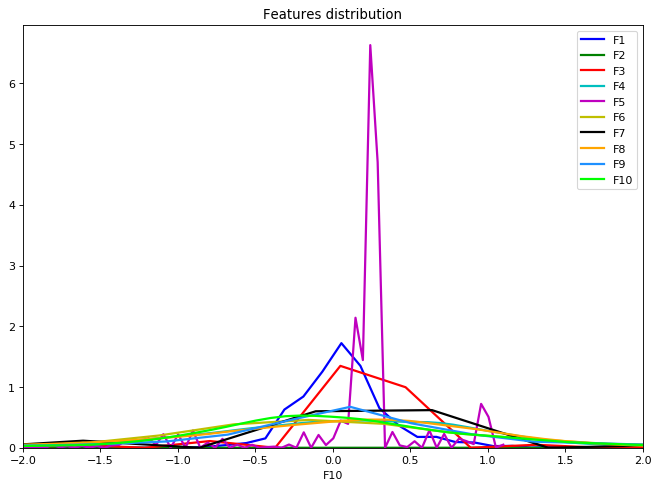

In [0]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,7), dpi= 80)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange','dodgerblue','lime']
for column,col in zip(X_train,colours):
    sns.distplot(X_train[column], color=col, label=column, **kwargs, hist=False)
plt.xlim(-2,2)
plt.title("Features distribution")
plt.legend();


## 1.1 Outliers analysis

### 1.1.1 Boxplots

The boxplot is a quantitative graph which summarizes in a univoque way the distribution of data starting from minimum, 1° quartile (Q1, 25%), median, 3° quartile (Q3, 75%) and maximum and provide an intuitive representation of how the data are disperded.
The wide between Q1 and Q2 is named 'interquartile range' (IQR); the maximum and the minimum are not the data's maximum and minimum but they are computed respectively as Q3 + 1.5xIQR and Q1 -1.5xIQR.
The points outside the range [minimum,maximum] are considered *outliers* because they are too far from the central values and so, they are not in the range in which we expect them.

As it is easy to observe in the plot below, in the original data there is a signficiative outlier for F2 attribute: this data has been removed for better analysis.


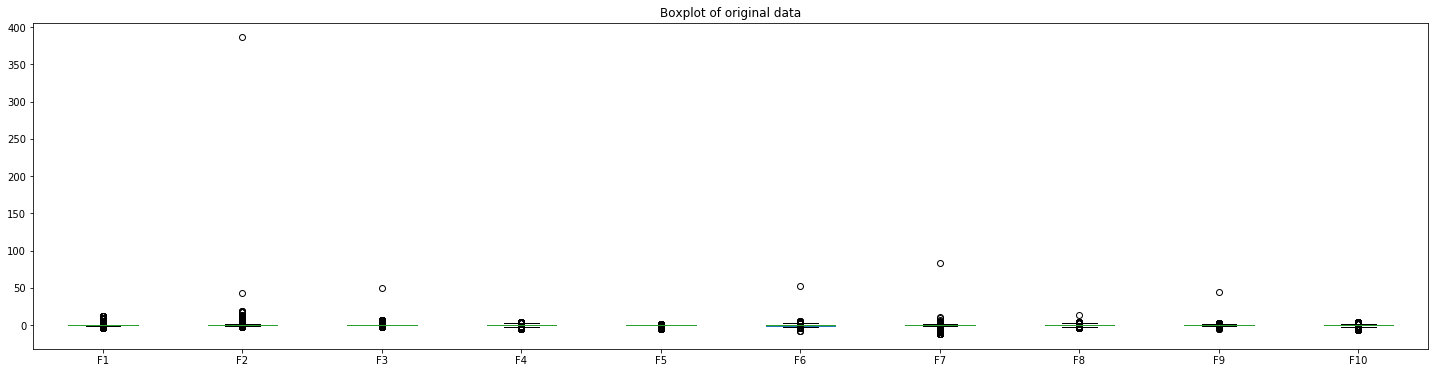

In [0]:
X_train.plot(kind='box',figsize=(25,6))
plt.title("Boxplot of original data")
plt.show()

In [0]:
train_data_2 = train_data.drop(train_data.index[train_data['F2'] > 300].tolist()) 
X_train_2 = train_data_2.iloc [:, [0,1,2,3,4,5,6,7,8,9]] 
Y_train_2 = train_data_2.iloc [:, [10]] 

From the new plot, it's possible to observe that the data with the outlier value for F2 attribute, contained outlier values also for *F6*, *F7* and *F9* for which no more values higher than 30 are present.

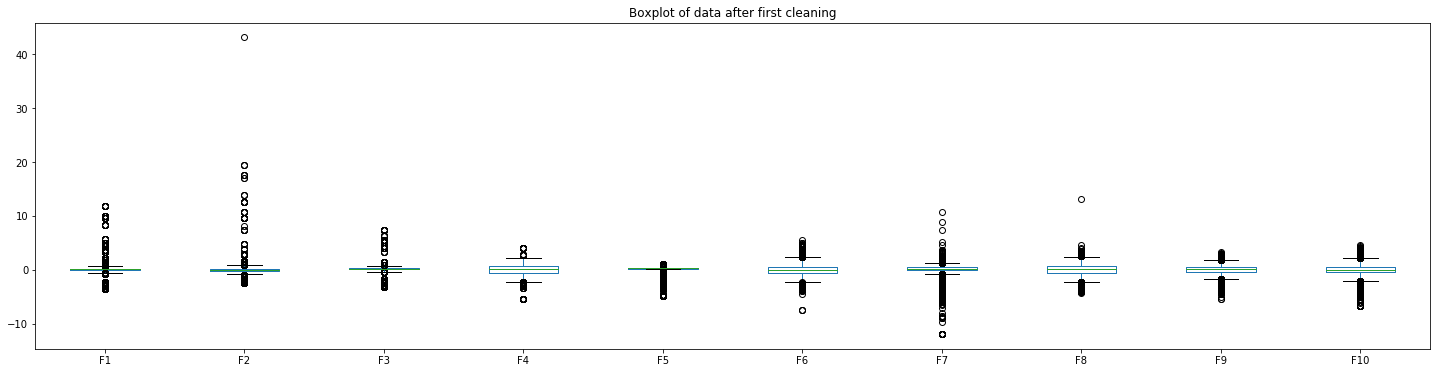

In [0]:
X_train_2.plot(kind='box',figsize=(25,6))
plt.title("Boxplot of data after first cleaning")
plt.show()

However a further removal of the visible *F2* outlier and *F8* one is necessary and the plot below is obtained.   
Despite the removals, the values of the features results very scattered with respect to the median value and out of the interquartile range.
Even if with some visual difficulties, it's important to notice that data are symmetric distributed for most features because of the normalization. Some exceptions are *F2* and *F5*, for which zoomed plots are reported together with *F4* and *F10* ones.

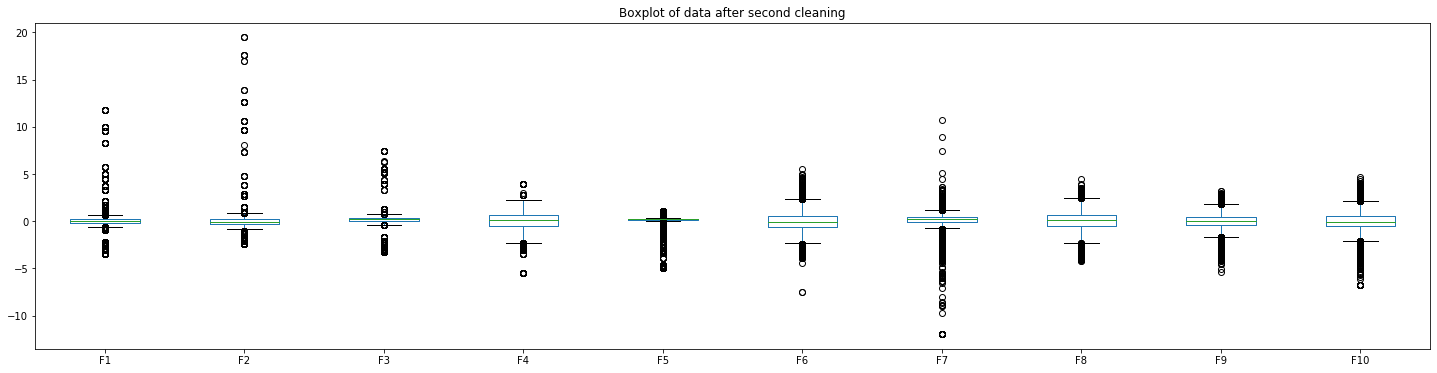

In [0]:
train_data_2 = train_data_2.drop(train_data_2.index[train_data_2['F2'] > 40].tolist()) 
train_data_2 = train_data_2.drop(train_data_2.index[train_data_2['F8'] > 10].tolist()) 
X_train_2 = train_data_2.iloc [:, [0,1,2,3,4,5,6,7,8,9]] 
Y_train_2 = train_data_2.iloc [:, [10]] 
X_train_2.plot(kind='box',figsize=(25,6))
plt.title("Boxplot of data after second cleaning")
plt.show()

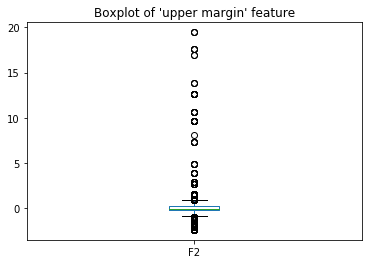

In [0]:
X_train_2['F2'].plot(kind='box')
plt.title("Boxplot of \'upper margin\' feature")
plt.show()

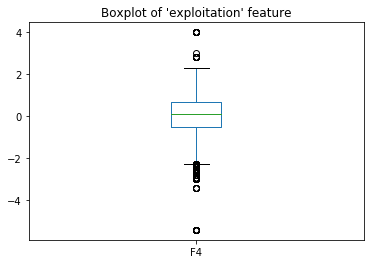

In [0]:
X_train_2['F4'].plot(kind='box')
plt.title("Boxplot of \'exploitation\' feature")
plt.show()

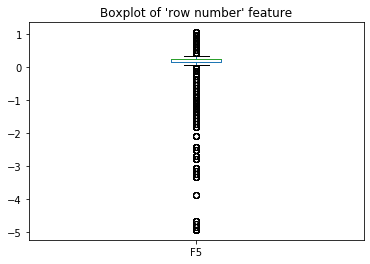

In [0]:
X_train_2['F5'].plot(kind='box')
plt.title("Boxplot of \'row number\' feature")
plt.show()

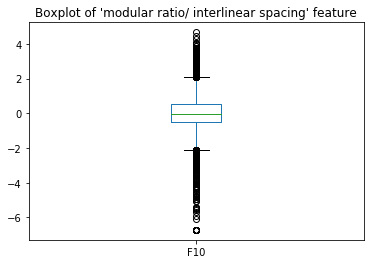

In [0]:
X_train_2['F10'].plot(kind='box')
plt.title("Boxplot of \'modular ratio/ interlinear spacing\' feature")
plt.show()

#### Descriptive statistics of training dataset after boxplot outliers detection and removal

In [0]:
pd.options.display.float_format = "{:.3f}".format 
print(X_train_2.describe(include="all"))

             F1        F2        F3        F4        F5        F6        F7  \
count 10428.000 10428.000 10428.000 10428.000 10428.000 10428.000 10428.000   
mean      0.001    -0.008    -0.005    -0.002     0.007     0.010    -0.001   
std       0.991     0.954     1.007     1.007     0.991     0.997     1.026   
min      -3.499    -2.427    -3.211    -5.440    -4.922    -7.450   -11.935   
25%      -0.129    -0.262     0.065    -0.528     0.172    -0.599    -0.044   
50%       0.044    -0.056     0.218     0.096     0.262    -0.059     0.220   
75%       0.204     0.203     0.353     0.658     0.262     0.564     0.447   
max      11.820    19.470     7.459     3.987     1.066     5.505    10.715   

             F8        F9       F10  
count 10428.000 10428.000 10428.000  
mean      0.009     0.009     0.001  
std       0.995     0.997     1.005  
min      -4.248    -5.424    -6.719  
25%      -0.542    -0.372    -0.516  
50%       0.112     0.064    -0.035  
75%       0.655     0.

#### Features distribution of training dataset after boxplot outliers detection and removal

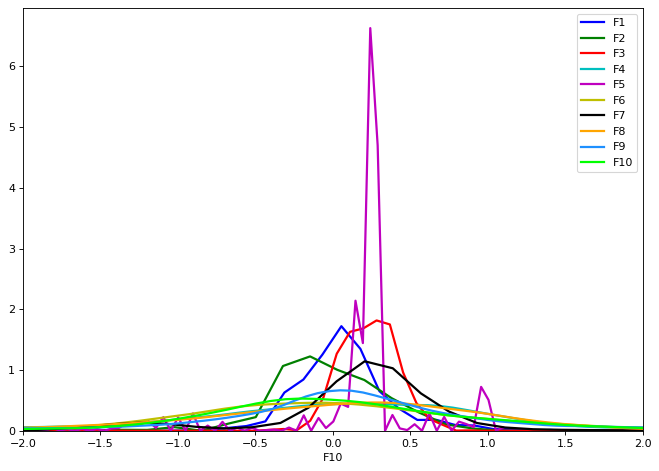

In [0]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,7), dpi= 80)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange','dodgerblue','lime']
for column,col in zip(X_train_2,colours):
    sns.distplot(X_train_2[column], color=col, label=column, **kwargs, hist=False)
plt.xlim(-2,2)
plt.legend();

### 1.1.2 Mahalanobis

Mahalobis distance provides a good way for outliers detection in multidimensional data. It is a distance metric between two points that in our analysis is used to evaluate the distance of an observation from a distribution (identified by the mean value of it). It can be seen as a multivariate variant of the Euclidean distance and it is computed according to the following formula:     

<center><p style="text-align: center;">D = $\sqrt{(x-m)^TC^{-1}(x-m)}$</p></center>

where:   
* D is the Mahalanobis distance
* x is the matrix of observations;
* m is the mean of values;
* C is the covariance matrix;

The division by the covariance matrix address the problem of data correlation, scaling the distance according to the strenght of the correlation; the higher the correlation, the higher is the scaling.



In [0]:
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if cov is None:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

Plotting the mahalanobis distances of the original training set, confirms the previous removals of outliers.

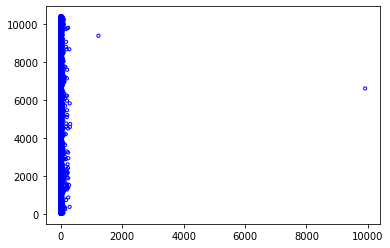

In [0]:
x_train = X_train.values
M = np.mean(x_train.T, axis=1)

# center columns by subtracting column means
C = x_train - M
# calculate covariance matrix of centered matrix
V = np.cov(C.T)

m_dist = mahalanobis(X_train, X_train.mean(axis=1),V)

plt.scatter(m_dist,range(X_train.shape[0]),s=10, facecolors='none', edgecolors='b')
plt.show()




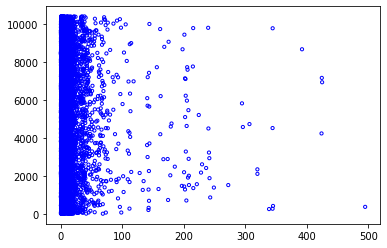

In [0]:
x_train = X_train_2.values
M = np.mean(x_train.T, axis=1)

# center columns by subtracting column means
C = x_train - M
# calculate covariance matrix of centered matrix
V = np.cov(C.T)

m_dist = mahalanobis(X_train_2, X_train_2.mean(axis=1),V)

plt.scatter(m_dist,range(X_train_2.shape[0]),s=10, facecolors='none', edgecolors='b')
plt.show()



So the mahalanobis distances are computed and plotted for the training set without the previous indicated outliers:
the points with a mahalanobis distance greater than 250 has been considered outliers and have been removed from the training set.

In [0]:
#No_outliers
indexes = [i for i,e in enumerate(m_dist) if e<250]
X_train_3 = X_train_2[X_train_2.index.isin(indexes)]
Y_train_3 = Y_train_2[Y_train_2.index.isin(indexes)]

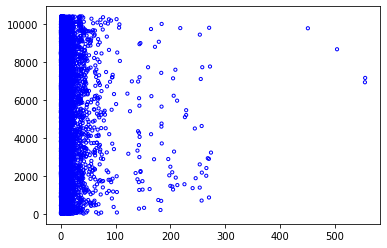

In [0]:
x_train = X_train_3.values
M = np.mean(x_train.T, axis=1)

# center columns by subtracting column means
C = x_train - M
# calculate covariance matrix of centered matrix
V = np.cov(C.T)

m_dist = mahalanobis(X_train_3, X_train_3.mean(axis=1),V)

plt.scatter(m_dist,range(X_train_3.shape[0]),s=10, facecolors='none', edgecolors='b')
plt.show()

#### Descriptive statistics of the cleaned training dataset

In [0]:
pd.options.display.float_format = "{:.3f}".format 
print(X_train_3.describe(include="all"))

             F1        F2        F3        F4        F5        F6        F7  \
count 10410.000 10410.000 10410.000 10410.000 10410.000 10410.000 10410.000   
mean      0.003    -0.020    -0.004    -0.002     0.011     0.011     0.004   
std       0.982     0.832     1.006     1.007     0.982     0.994     0.986   
min      -3.499    -2.427    -3.211    -5.440    -4.922    -7.450   -11.935   
25%      -0.129    -0.268     0.065    -0.528     0.172    -0.599    -0.044   
50%       0.044    -0.056     0.218     0.096     0.262    -0.059     0.220   
75%       0.204     0.203     0.353     0.658     0.262     0.564     0.447   
max      11.820    19.470     7.459     3.987     1.066     5.505     8.903   

             F8        F9       F10  
count 10410.000 10410.000 10410.000  
mean      0.007     0.012     0.006  
std       0.993     0.992     0.991  
min      -4.248    -5.050    -6.719  
25%      -0.543    -0.341    -0.514  
50%       0.111     0.064    -0.033  
75%       0.654     0.

#### Features distribution on the cleaned training dataset

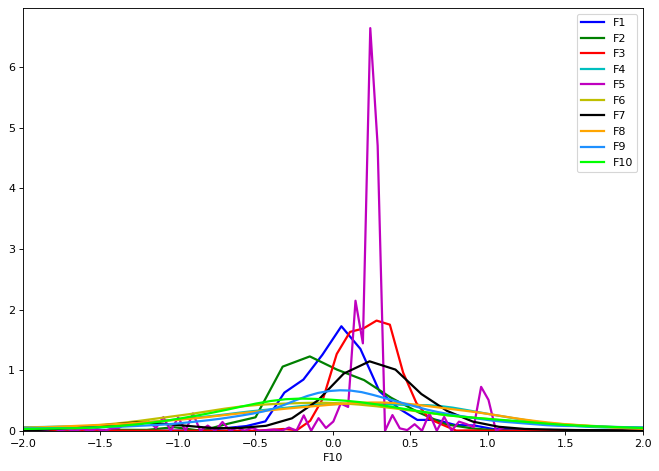

In [0]:
kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})
plt.figure(figsize=(10,7), dpi= 80)
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange','dodgerblue','lime']
for column,col in zip(X_train_3,colours):
    sns.distplot(X_train_3[column], color=col, label=column, **kwargs, hist=False)
plt.xlim(-2,2)
plt.legend();

In [0]:
train_data_3 = pd.concat([X_train_3, Y_train_3], axis = 1)

## 1.2 Correlation analysis

The correlation matrix is a method to visualize the correlation among features. In this case the corr() method of Pandas dataframe is used to evaluate the correlation matrix thorugh the Pearson method, known as “product moment correlation coefficient” (PMCC).
The coefficient is a number between -1 and 1 and it indicates how much two variables are lnearly related.

The correlation matrices are computed for the cleaned data and also for the original one in order to see how the pre-processing impacted on the correlation among features.   

As it is possible to see in the figures below, taking as point of reference mostly the correlation matrix for the cleaned data, there are no particularly related features apart from the obvious high positive correlation between *modular ratio/ interlinear spacing (F10)* and *modular ratio(F6)*, being the former direclty proportional to the latter.
Some moderate positive correlation is also present between *intercolumnar distance (F1)* and *row number (F5)* and between *weight (F8)* and *peak number(F9)*  as it is visible in the scattering plots .

#### Correlation matrix on original data

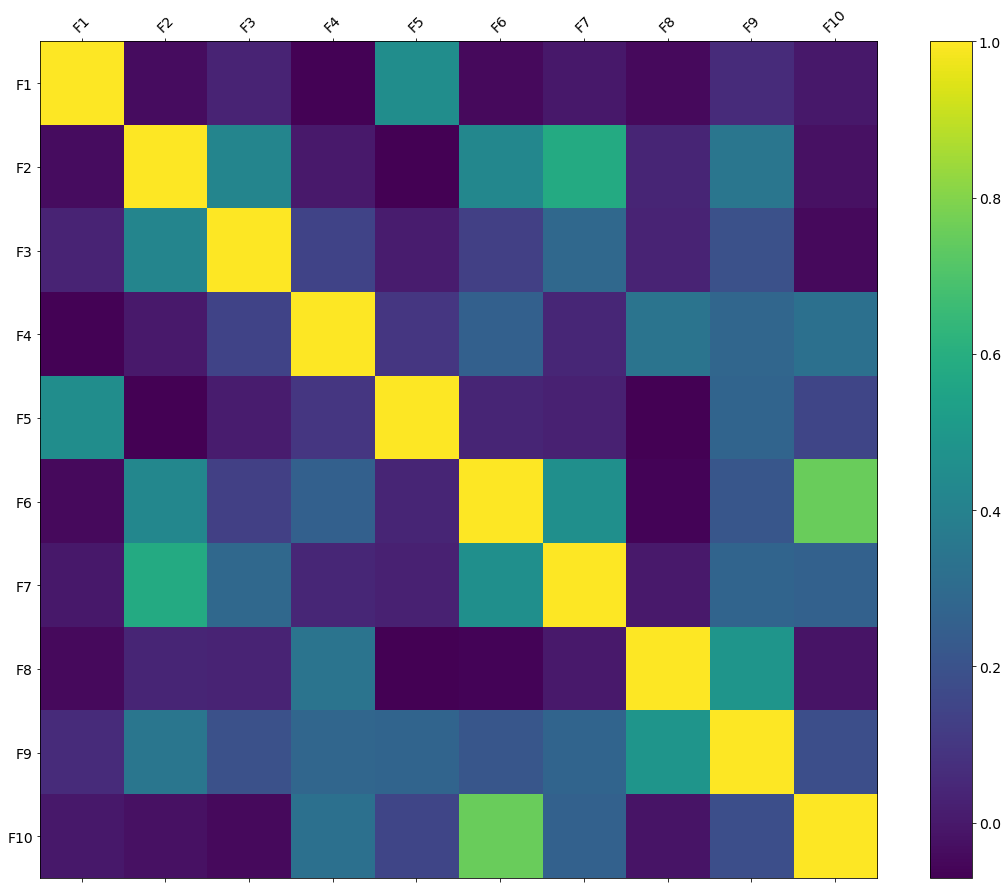

In [0]:
#CORRELATION MATRIX ON ORIGINAL DATA
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train.corr(), fignum=f.number)
plt.xticks(range(X_train.shape[1]), X_train.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train.shape[1]), X_train.columns, fontsize=14)
bottom, top = plt.gca().get_ylim()
plt.ylim(bottom + 0.5, top - 0.5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

#### Correlation matrix on original data

In [0]:
# CORRELATION MATRIX on orgiginal data with Pearson index
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
F1,1,-0.0376,0.0345,-0.0653,0.452,-0.0447,-0.00117,-0.0433,0.0594,-0.00284
F2,-0.0376,1,0.415,0.00203,-0.0678,0.424,0.582,0.0412,0.349,-0.0248
F3,0.0345,0.415,1,0.144,0.0113,0.133,0.289,0.035,0.193,-0.0454
F4,-0.0653,0.00203,0.144,1,0.0964,0.258,0.0439,0.339,0.281,0.324
F5,0.452,-0.0678,0.0113,0.0964,1,0.0398,0.0264,-0.0712,0.275,0.152
F6,-0.0447,0.424,0.133,0.258,0.0398,1,0.463,-0.0596,0.214,0.756
F7,-0.00117,0.582,0.289,0.0439,0.0264,0.463,1,0.00244,0.272,0.263
F8,-0.0433,0.0412,0.035,0.339,-0.0712,-0.0596,0.00244,1,0.488,-0.016
F9,0.0594,0.349,0.193,0.281,0.275,0.214,0.272,0.488,1,0.186
F10,-0.00284,-0.0248,-0.0454,0.324,0.152,0.756,0.263,-0.016,0.186,1


#### Scatter plot of modular ratio and modular ratio/ interlinear spacing 

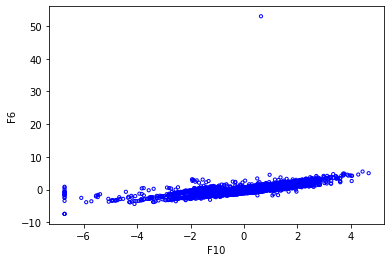

In [0]:
plt.scatter(X_train['F10'],X_train['F6'],s=10, facecolors='none', edgecolors='b')
plt.ylabel('F6')
plt.xlabel('F10')
plt.show()

#### Scatter plot of upper margin and interlinear spacing

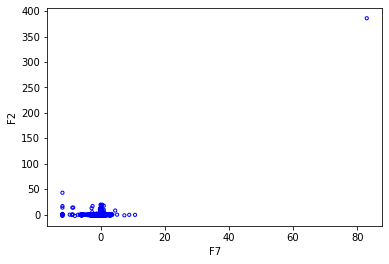

In [0]:
plt.scatter(X_train['F7'],X_train['F2'],s=10, facecolors='none', edgecolors='b')
plt.ylabel('F2')
plt.xlabel('F7')
plt.show()

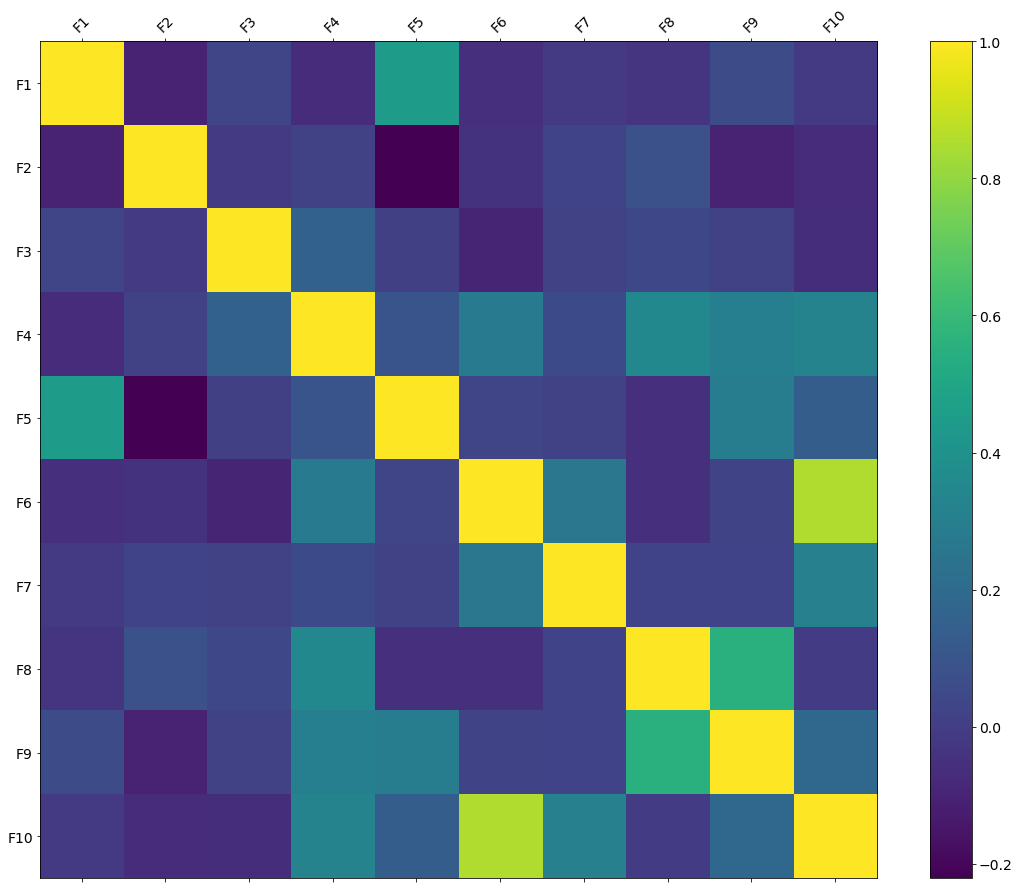

In [0]:
#CORRELATION MATRIX ON cleaned DATA
f = plt.figure(figsize=(19, 15))
plt.matshow(X_train_3.corr(), fignum=f.number)
plt.xticks(range(X_train_3.shape[1]), X_train_3.columns, fontsize=14, rotation=45)
plt.yticks(range(X_train_3.shape[1]), X_train_3.columns, fontsize=14)
bottom, top = plt.gca().get_ylim()
plt.ylim(bottom + 0.5, top - 0.5)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [0]:
# CORRELATION MATRIX on cleaned data with Pearson index
corr = X_train_3.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
F1,1,-0.106,0.036,-0.066,0.449,-0.0566,-0.0147,-0.0353,0.0587,-0.0135
F2,-0.106,1,-0.0129,0.0202,-0.221,-0.0434,0.024,0.0842,-0.0979,-0.0682
F3,0.036,-0.0129,1,0.157,0.00819,-0.0923,0.0194,0.0429,0.0184,-0.0635
F4,-0.066,0.0202,0.157,1,0.0968,0.288,0.052,0.349,0.306,0.326
F5,0.449,-0.221,0.00819,0.0968,1,0.0344,0.0156,-0.0575,0.289,0.139
F6,-0.0566,-0.0434,-0.0923,0.288,0.0344,1,0.264,-0.0584,0.0273,0.855
F7,-0.0147,0.024,0.0194,0.052,0.0156,0.264,1,0.0258,0.0243,0.309
F8,-0.0353,0.0842,0.0429,0.349,-0.0575,-0.0584,0.0258,1,0.552,-0.0039
F9,0.0587,-0.0979,0.0184,0.306,0.289,0.0273,0.0243,0.552,1,0.187
F10,-0.0135,-0.0682,-0.0635,0.326,0.139,0.855,0.309,-0.0039,0.187,1


#### Scatter plot of modular ratio and modular ratio/ interlinear spacing 

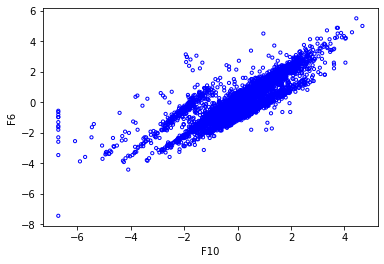

In [0]:
plt.scatter(X_train_3['F10'],X_train_3['F6'],s=10, facecolors='none', edgecolors='b')
plt.ylabel('F6')
plt.xlabel('F10')
plt.show()

#### Scatter plot of upper margin and row number 

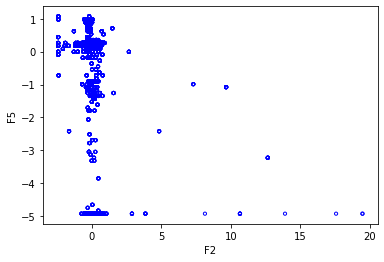

In [0]:
plt.scatter(X_train_3['F2'],X_train_3['F5'],s=10, facecolors='none', edgecolors='b')
plt.ylabel('F5')
plt.xlabel('F2')
plt.show()

# 2. Dimensionality reduction

## 2.1 PCA

Principal Component Analysis is an unsupervised technique constinting in finding orthonormal basis of a space on which project data in order to maximize the observed variance and minimize the mean distance between original data and projections, i.e. keep as much information as possible minimizing the squared error.   
The PCA algorithm assumes the data are centered, so PCA components are computed from centers of mass of the data.   

In this case, even if the original data was already normalized, a StandardScaler is used to renormalize the data after the previous removal of the outliers.   

The basic PCA algorithm is based on obtaining the principal components sequentially, starting from the first one as the versor in the direction of maximal data variance and then the subsequents as the ones ortoghonal to the previous and in the direction of maximal variance in the residual space, according to:
    
<center><p style="text-align: center;">$w_1 = \underset{\left\lVert w\right\rVert = 1}{\operatorname{argmax}}\frac{1}{N}\sum\limits_{i=1}^N{(w^T x_i)^2}$</p> 

<p style="text-align: center;">$w_k = \underset{\left\lVert w\right\rVert = 1}{\operatorname{argmax}}\frac{1}{N}\sum\limits_{i=1}^N{[w^T(x_i - \sum\limits_{j=1}^{k-1}{w_j w_j^T x_i})]^2}$</p></center>

However, generally, sample covariance matrix or SVD (Singular Variance Decomposition) based techniques are used.

According to the former, the PCA components are the eigenvectors of the sample covariance matrix. The eigenvectors associated with the highest eigenvalues are the most important,i.e. they are associated with the most data variance: the total explained variance is the sum of the eigenvalues of the covariance matrix and each eigenvector's proportion variance explained is computed as:

<center><p style="text-align: center;">$variance_i =\frac{\lambda_i}{\sum\limits_{j=1}^d{\lambda_j}}$</p></center>

where $\lambda_i$ is the eigenvalues associated with the *i*-th eigenvector and *d* is the data dimensionality.

From the point of view of dimensionality reduction, the number of basis identifying the new space is a trade-off between the percentage of variance desired to keep and the dimensionality.


In [0]:
le = LabelEncoder()
label_train = le.fit_transform(train_data_3['class'])
label_test = le.transform(test_data['class'])
label = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'W', 'X', 'Y']

In [0]:
X_train_cent = StandardScaler().fit_transform(X_train_3)

In [0]:
#pca = PCA(n_components = 0.95, svd_solver = 'full')
pca = PCA()
principalComponents = pca.fit_transform(X_train_cent)
principalDf = pd.DataFrame(data = principalComponents)
data_PCA = pd.concat([principalDf, Y_train_3], axis = 1)
#finalDf = finalDf.drop([10428,10429])
#print(finalDf)

Variance explained by each component: 
 [23.2 17.2 15.6 10.3  9.4  8.6  5.7  5.6  3.1  1.2]
Cumulative sum of variance explained with [n] features: 
 [23.2 40.4 56.  66.3 75.7 84.3 90.  95.6 98.7 99.9]


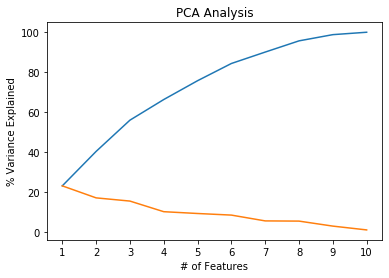

In [0]:
variance = pca.explained_variance_ratio_ #calculate variance ratios
variance = np.round(variance, decimals=3)*100
print("Variance explained by each component: \n", variance)

var=np.cumsum(variance)
var #cumulative sum of variance explained with [n] features
print("Cumulative sum of variance explained with [n] features: \n", var)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.xticks(np.arange(0, 10, step=1),[1,2,3,4,5,6,7,8,9,10])
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.plot(variance)
plt.show()


From the application of the linear PCA algorithm without constraints on the number of principal components to obtain and on the total variance to keep, it's possible to observe all the 10 principal components maximizing the variance of the train dataset and their related individual and cumulative explained variance.

According to the results of the application of linear PCA to our data, the dimensionality reduction is not a good idea because to keep the 90% of variance, 7 features over 10 are necessary and the first 2 components explain only the 41.6% of variance and the first 3 the 57%.

### 2.1.1 Kernel PCA

The standard PCA algorithm suffers from the problem of inability to deal with non linear structure.
As this algorithm can be expressed only in function of dot products, the kernel trick can be adopted to solve non linear problems. 
In general to apply PCA to non linear structure, a mapping of the data points in a higher dimensional space can be adopted in which the structure is linear and the PCA can be applied normally.   
However the mapping of the features in a new space is difficult and computational expensive as it requires features engineering and operation for each data.   
A kernel is a symmetric function on *x* and *x'* that can be interpreted as the dot product of *x* and *x'* in some feature space (higher dimensional): this allows to extend the PCA algorithm to non linear structure without explicitily solve the mapping.

In this analysis, the kernel PCA is tested on the data according to two commons kernel, the *rbf* and the *cosine* ones in order to explore the possibilities of having better representation of data as the linear kernel performance were not so good.


In [0]:
Kpca = KernelPCA(n_components = 10, kernel = 'rbf')
KprincipalComponents = Kpca.fit_transform(X_train_cent)
KprincipalDf = pd.DataFrame(data = KprincipalComponents)
data_KPCA = pd.concat([KprincipalDf, Y_train_3], axis = 1)

In [0]:
Kpca_2 = KernelPCA(n_components = 10, kernel = 'cosine')
KprincipalComponents2 = Kpca.fit_transform(X_train_cent)
KprincipalDf2 = pd.DataFrame(data = KprincipalComponents2)
data_KPCA2 = pd.concat([KprincipalDf2, Y_train_3], axis = 1)

Variance explained by each component: 
 [25.5 20.1 17.3  8.1  7.3  6.   4.5  4.2  4.   3.2]
Cumulative sum of variance explained with [n] features: 
 [ 25.5  45.6  62.9  71.   78.3  84.3  88.8  93.   97.  100.2]


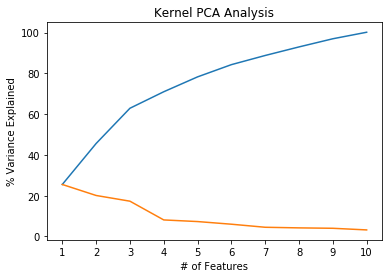

In [0]:
explained_variance = np.var(KprincipalComponents, axis=0)
variance = explained_variance / np.sum(explained_variance)
variance = np.round(variance, decimals=3)*100
print("Variance explained by each component: \n", variance)

var=np.cumsum(variance)
var #cumulative sum of variance explained with [n] features
print("Cumulative sum of variance explained with [n] features: \n", var)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('Kernel PCA Analysis')
plt.xticks(np.arange(0, 10, step=1),[1,2,3,4,5,6,7,8,9,10])
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.plot(variance)
plt.show()



Variance explained by each component: 
 [25.5 20.1 17.3  8.1  7.3  6.   4.5  4.2  4.   3.2]
Cumulative sum of variance explained with [n] features: 
 [ 25.5  45.6  62.9  71.   78.3  84.3  88.8  93.   97.  100.2]


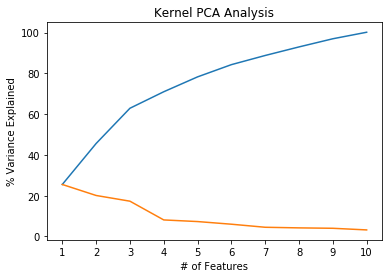

In [0]:
explained_variance = np.var(KprincipalComponents2, axis=0)
variance = explained_variance / np.sum(explained_variance)
variance = np.round(variance, decimals=3)*100
print("Variance explained by each component: \n", variance)

var=np.cumsum(variance)
var #cumulative sum of variance explained with [n] features
print("Cumulative sum of variance explained with [n] features: \n", var)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('Kernel PCA Analysis')
plt.xticks(np.arange(0, 10, step=1),[1,2,3,4,5,6,7,8,9,10])
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.plot(variance)
plt.show()

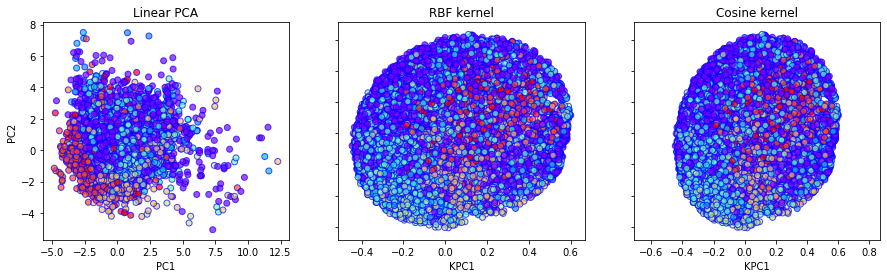

In [0]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,4))
plt.gca().set_aspect('equal', adjustable='datalim')
ax1.scatter(
    principalComponents[:,0],
    principalComponents[:,1],
    c=label_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_title('Linear PCA')

ax2.scatter(
    KprincipalComponents[:,0],
    KprincipalComponents[:,1],
    c=label_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

ax2.set_xlabel('KPC1')
ax2.set_ylabel('KPC2')
ax2.set_title('RBF kernel')

ax3.scatter(
    KprincipalComponents2[:,0],
    KprincipalComponents2[:,1],
    c=label_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

ax3.set_xlabel('KPC1')
ax3.set_ylabel('KPC2')
ax3.set_title('Cosine kernel')

for ax in fig.get_axes():
    ax.label_outer()

For both the kernels, the results are not so different with respect to the ones obtained with the linear kernel and they don't show any convenience in reducing the space dimensionality.

The data projected on the 2D space indviduated by the first 2 principal components and on the 3D one obtained with the first 3 components are shown for all the kernels only to provide a graphical view of the PCA results, but as it is possible to observe the projection seems to be not so much significative.

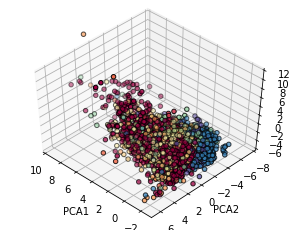

In [0]:
fig = plt.figure(figsize=(5.5, 3))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(np.float)
sc = ax.scatter( principalComponents[:,0],  principalComponents[:,1],  principalComponents[:,2], c=label_train, cmap="Spectral", edgecolor='k')

ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

ax.set_xlim(-3,10)
ax.set_ylim(-8,7)
ax.set_zlim(-6,12)


plt.show()

In [0]:
X_train_PCA = principalComponents
X_train_KPCA = KprincipalComponents
X_test_KPCA = Kpca.transform(X_test)
X_test_PCA = pca.transform(X_test)

## 2.1 LDA

LDA is a technique very similar to the PCA but able to provide additional information: besides maximizing the variance, the LDA algorithm tries also to keep the information about classes separation.
Also this technique is linear and it is moslty used for projecting the data into a lower dimensional space, but it can be also adapted for classification tasks, as it tries to maximize the classes discrimination.

Generally LDA outperforms PCA for multi-class problems.

Also LDA assumes normal distribution of data and statistically independence of features and identical covariance matrices for every class even if, for dimensionality reduction task, it also performs well without this assumptions.




Variance explained by each component: 
 [63.2 15.1 10.6  7.5  2.   1.   0.4  0.1  0.   0. ]
Cumulative sum of variance explained with [n] features: 
 [63.2 78.3 88.9 96.4 98.4 99.4 99.8 99.9 99.9 99.9]


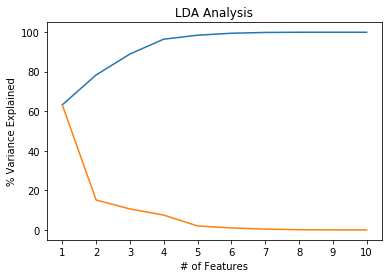

In [0]:
lda = LinearDiscriminantAnalysis()
X_lda = lda.fit_transform(X_train_3, Y_train_3.values.ravel())
variance = lda.explained_variance_ratio_
variance = np.round(variance, decimals=3)*100
print("Variance explained by each component: \n", variance)

var=np.cumsum(variance)
var #cumulative sum of variance explained with [n] features
print("Cumulative sum of variance explained with [n] features: \n", var)

plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('LDA Analysis')
plt.xticks(np.arange(0, 10, step=1),[1,2,3,4,5,6,7,8,9,10])
plt.style.context('seaborn-whitegrid')
plt.plot(var)
plt.plot(variance)
plt.show()


From the application of the LDA to the training set, differenlty fromn PCA, it results convenient to halve the number of dimensions for the data as considering only the first 4 features guarantees to keep the 96.4 % of total explained variance.
For graphical reasons the plots below reports the data projected into a 2D and 3D spaces indeitfied respectively by the first 2 and 3 principal componets: even if with 2 and 3 components only the 78.3% and the 88.9% of variance is explained with respect to the 96.4% of taking the first 4 principal components, it's already possible observe the difference of data representation with respect to the PCA, especially in a more clear separation of classes.

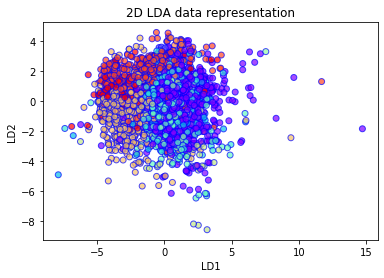

In [0]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('2D LDA data representation')
plt.scatter(
    X_lda[:,0],
    X_lda[:,1],
    c=label_train,
    cmap='rainbow',
    alpha=0.7,
    edgecolors='b'
)

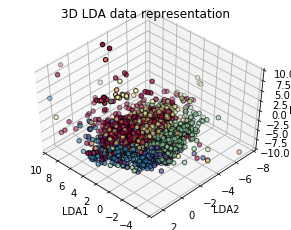

In [0]:
fig = plt.figure(figsize=(5.5, 3))
ax = Axes3D(fig, rect=[0, 0, .7, 1], elev=48, azim=134)

# Reorder the labels to have colors matching the cluster results
#y = np.choose(y, [1, 2, 0]).astype(np.float)
sc = ax.scatter( X_lda[:,0],  X_lda[:,1],  X_lda[:,2], c=label_train, cmap="Spectral", edgecolor='k')

ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_zlabel('LDA3')

ax.set_xlim(-6,10)
ax.set_ylim(-8,3)
ax.set_zlim(-10,10)
ax.set_title('3D LDA data representation')


plt.show()

In [0]:
X_train_LDA = X_lda[:,[0,1,2,3]]
X_test_LDA = (lda.transform(X_test))[:,[0,1,2,3]]

# 3. Classification techniques

AVILA dataset lends itself very well for classification tasks and in this work the experiments done with different classification techniques are reported. Particoularly the following sections are present:

* 3.2 Linear and Kernel SVM
* 3.3 K-neighbours
* 3.4 Logistic Regression
* 3.5 Decision Tree
* 3.6 Random Forest
* 3.7 Gaussian NB
* 3.8 LDA as classification

## 3.0 Cross validation

SVM, K-neighbors, Decision tree and Random Forest require hyperparameters tuning in order to find the parameters for which the model's performance are maximized: the K-fold approach is adopted.

Cross validation consists in splitting the original dataset in training, validation and test set and then performing the following steps:
* train/fit several models *h* with different hyperparameters sets on the training dataset;
* evaluate the performance, generally in term of accuracy, of the various models on the validation dataset and choose the hyperparameters associated with the best performing model;
* train the model characterized by the chosen parameters on the concatenation of training and validation step;
* estimate the true risk of the trained model on the test set, i.e. evaluate the model's performance.

K-fold is a particoular implementation of cross validation generally providing lower bias with respect to other methods and consisting in the following steps:

* the training set is splitted in K chunks;
* for each hyperparameters set to evaluate, a model is trained over K-1 chunks while the K-th chunk is used as validation set; this step is repeated K time: at the end each chunk, and so each sample, has been used K-1 time as part of training set and 1 time as validation set.
* the perfomance scores of the various models are then summarized for each model, for example through mean of the K accuracy values;
* the best performing model is chosen and evaluated on the test set.

In this work K = 5 has been choosen for the k-fold cross validation and a grid search layout is adopted to explore the hyperparameters' values to test.

In [0]:
def FiveFoldValidation(model,tuned_parameters,x_train,y_train):
    kfolds= KFold(5)

    #Perform the grid search for C and Gamma through the 5-fold cross-validation on new training set
    clf = GridSearchCV(model, tuned_parameters, cv=kfolds.split(x_train,y_train),scoring='accuracy')
    clf.fit(x_train, y_train.values.ravel())


    #Printing of the best parameters found
    print("Best parameters set found on the validation set:")
    print()
    params=clf.best_params_
    print(params)
    return params

def test(model,x_train,y_train,x_test,y_test):

    #Retraining of the model chosen on the training set
    model.fit(x_train,y_train.values.ravel())

    #Evaluation of the accuracy on the test_set
    Y_test_pred=model.predict(x_test)

    print()
    accuracy = accuracy_score(y_test,Y_test_pred)
    #print('Evaluation of the model with C= ' + str(params['C']) +' on the test set')
    print('Accuracy=%.3f'%(accuracy))
    precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(y_test, Y_test_pred, average='macro')
    print(f"Precision: %.3f\nRecall: %.3f\nF1-score: %.3f"%(precision,recall,f1_score))
    matrix = confusion_matrix(y_test, Y_test_pred)
    return matrix, accuracy, precision, recall, f1_score

def plot_confusion_matrix(matrix,size,title):
    fig, ax = plt.subplots(figsize=size)
    ax = sns.heatmap(matrix, cmap='Blues', annot=True)

    ax.set_xticklabels(label, rotation = 0, fontsize=13)
    ax.set_yticklabels(label, rotation = 0, fontsize=13)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    ax.set_title(title, fontweight="bold")
    bottom, top = plt.gca().get_ylim()
    plt.ylim(bottom + 0.5, top - 0.5)
    

In [0]:
accuracy_d = {}
precision_d = {}
recall_d = {}
f1_score_d = {}

accuracy_d_pca = {}
precision_d_pca = {}
recall_d_pca = {}
f1_score_d_pca = {}

accuracy_d_kpca = {}
precision_d_kpca = {}
recall_d_kpca = {}
f1_score_d_kpca = {}

accuracy_d_lda = {}
precision_d_lda = {}
recall_d_lda = {}
f1_score_d_lda = {}

## 3.1 Evaluation metrics

The perfomance of each method are evaluated in terms of:

* **accuracy:** it expresses the ratio between the correctly classified samples versu total number of samples;
* **precision:** it expresses the ratio between the correctly predicted samples of a class and  all the samples predicted to belong to that class;
* **recall:** for each actual class, it indicates how many samples are correclty classified in the class;
* **F1_score:** a weighted sum of recall and precision useful when classes are not balanced;
* **confusion matrix:** a graphical way to represent in form of matrix the correclty and misclassified samples; each row represents the true classes and each column the predicted classes; at each interception (i,j) there is the number of samples classified as j and belong to i: the correclty classified samples are the ones on the diagonal of the matrix.   

<center><p style="text-align: center;">$accuracy = \frac{\#\;correctly\;classified\;samples}{\#\;total\;samples} $</p> 

<p style="text-align: center;">$precision = \frac{\#\;correctly\;classified\;samples\; as\;belonging\;to\;class\;K}{\#\;total\;samples\;predicted\;to\;belong\;to\;K} $</p> 

<p style="text-align: center;">$recall = \frac{\#\;correctly\;classified\;samples\;in\;the\;class\; K}{\#\;total\;sample\;in\;the\;class\; K} $</p>   

<p style="text-align: center;">$F1-score = \frac{2*recall*precision}{recall\; + \;precision} $</p></center>  



## 3.2 SVM

Support Vector Machine is a supervised classification algorithm, born to solve binary classification but extendible to multi-class task through several technque like one-vs-rest.    
The standard approach assumes data are linearly separable and, assuming a binary problem, consists in finding the linear hyperplane separating the classes with the maximal margin:

<p style="text-align: center;">$\underset{ w,b }{\operatorname{argmax}}\frac{1}{\left\lVert w \right\rVert} subject\;to\;y_i[\langle x_i,w \rangle + b]\geq 1 $</p> 

that is

<p style="text-align: center;">$\underset{ w,b }{\operatorname{argmin}}\frac{{\left\lVert w \right\rVert}^2}{2} subject\;to\;y_i[\langle x_i,w \rangle + b]\geq 1 $</p> 

So, for binary problems:

for binary problems:

<p style="text-align: center;">$\langle w,x \rangle + b \leq -1 \;is\;the\;negative\;class$</p> 

<p style="text-align: center;">$\langle w,x \rangle + b \geq -1\;is\;the\;positive\;class$</p> 

Data are not always perfectly linear separable: in this case constraints on the margin can be relaxed adding slack variables;
for binary problems:

<p style="text-align: center;">$\langle w,x \rangle + b \leq -1 + \xi \;is\;the\;negative\;class$</p> 

<p style="text-align: center;">$\langle w,x \rangle + b \geq -1 - \xi \;is\;the\;positive\;class$</p> 

With slack variables the problem is called *soft margin problem* w.r.t. the *hard margin one* and it becomes:

<p style="text-align: center;">$\underset{ w,b }{\operatorname{argmin}}\frac{{\left\lVert w \right\rVert}^2}{2} + C\sum\limits_{i=1}{\xi_i}\;subject\;to\;y_i[\langle x_i,w \rangle + b]\geq 1-\xi_i\; and\;\xi_i \geq 0 $</p> 

C is an hyperparamer to tune and it represents the cost of misclassification: higher C, lower number of misclassified training data points.   

Because SVM algorithm can be expressed only through dot products, When data have not a linear structure, it's possible to appeal to the kernel trick, as already explained in the PCA section, taking as reference the dual formulation of SVM.

From soft margin:

<p style="text-align: center;">$\underset{ \alpha }{\operatorname{argmax}}-\frac{1}{2}\sum\limits_{i,j}{\alpha_i \alpha_j y_i y_j \langle x_i,x_j\rangle} + \sum\limits_{i}{\alpha_i}\;subject\;to\;\sum\limits_{i}{\alpha_i y_i}=0\;and; \alpha_i\;in\;[0,C]$</p> 

with the kernel trick it became:

<p style="text-align: center;">$\underset{ \alpha }{\operatorname{argmax}}-\frac{1}{2}\sum\limits_{i,j}{\alpha_i \alpha_j y_i y_j k(x_i,x_j)} + \sum\limits_{i}{\alpha_i}\;subject\;to\;\sum\limits_{i}{\alpha_i y_i}=0\;and; \alpha_i\;in\;[0,C]$</p> 

where $k(x_i,x_j)=\langle \Phi(x_i),\Phi(x_j) \rangle$

SVM can address the multi-class problem through the one vs all approach, in which the problem can be seen as applying the algorithm to one class versus each of the other class for all the classes and combining the results.

In this section the results obtained applying the linear SVM and the kernel extension of SVM on our dataset are reported.

### 3.2.1 Linear SVM

For linear SVM it's sufficient to tune the hyperparameter C while gamma is automatically ignored by the function.   
The algorithm is applied fitting the model to the cleaned data, to the projected data along the 4 LDA components, to the projected data along the PCA components and to the projected data along the Kernel PCA components.
For each of the models the 5-fold cross validation is performed on a range of C values empirically defined: it was observed that generally the models have better performance for higher values of C; however, for computational issue, the max C value tested in the range is 1000.    
The best performance are obtained for the data in the original space and for the projections on the PCA ones with a model characterized by C=1000.   
For data projections along the LDA components the best performing C is 100 and the accuracy reached is the lowest one among the model tested.   

Best parameters set found on the validation set:

{'C': 1000, 'gamma': 'auto'}

Accuracy=0.839
Precision: 0.880
Recall: 0.862
F1-score: 0.871


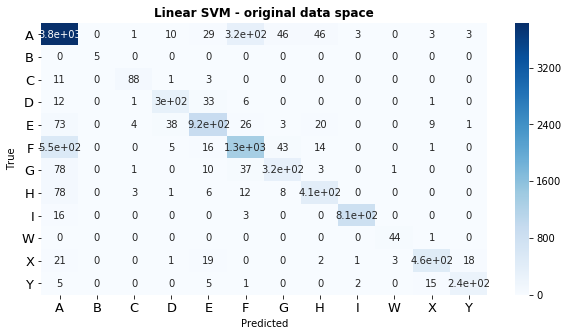

In [0]:
#5-FOLD CROSS VALIDATION WITH LINEAR KERNEL
C_values=[10,100,1000]
tuned_parameters = {'C': C_values,'gamma': ['auto']}
params=FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_3,Y_train_3)
m_SVM, accuracy, precision, recall, f1_score = test(svm.SVC(**params),X_train_3,Y_train_3,X_test,Y_test)
plot_confusion_matrix(m_SVM,(10,5),'Linear SVM - original data space')
accuracy_d['Linear SVM'] = accuracy
precision_d['Linear SVM'] = precision
recall_d['Linear SVM'] = recall
f1_score_d['Linear SVM'] = f1_score

Best parameters set found on the validation set:

{'C': 100, 'gamma': 'auto'}

Accuracy=0.622
Precision: 0.634
Recall: 0.487
F1-score: 0.523


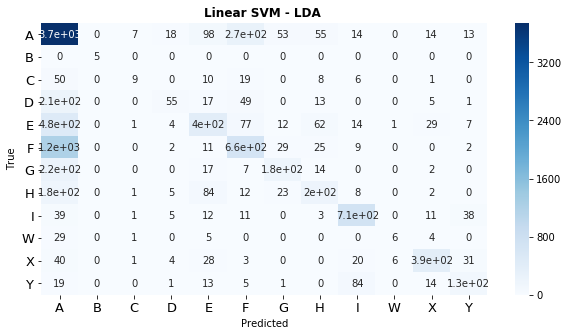

In [0]:
#5-FOLD CROSS VALIDATION WITH LINEAR KERNEL
C_values=[10,100,1000]
tuned_parameters = {'C': C_values,'gamma': ['auto']}
params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_LDA,Y_train_3)
m_SVM_LDA, accuracy, precision, recall, f1_score = test(svm.SVC(**params),X_train_LDA,Y_train_3,X_test_LDA,Y_test)
plot_confusion_matrix(m_SVM_LDA,(10,5),'Linear SVM - LDA ')
accuracy_d_lda['Linear SVM'] = accuracy
precision_d_lda['Linear SVM'] = precision
recall_d_lda['Linear SVM'] = recall
f1_score_d_lda['Linear SVM'] = f1_score

Best parameters set found on the validation set:

{'C': 1000, 'gamma': 'auto'}

Accuracy=0.823
Precision: 0.873
Recall: 0.785
F1-score: 0.816


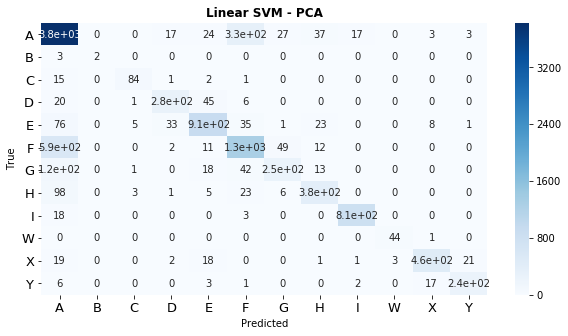

In [0]:
#5-FOLD CROSS VALIDATION WITH LINEAR KERNEL
C_values=[10,100,1000]
tuned_parameters = {'C': C_values,'gamma': ['auto']}

params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_PCA,Y_train_3)
m_SVM_PCA,accuracy, precision, recall, f1_score= test(svm.SVC(**params),X_train_PCA,Y_train_3,X_test_PCA,Y_test)
plot_confusion_matrix(m_SVM_PCA,(10,5),'Linear SVM - PCA')
accuracy_d_pca['Linear SVM'] = accuracy
precision_d_pca['Linear SVM'] = precision
recall_d_pca['Linear SVM'] = recall
f1_score_d_pca['Linear SVM'] = f1_score

Best parameters set found on the validation set:

{'C': 1000, 'gamma': 'auto'}

Accuracy=0.647
Precision: 0.576
Recall: 0.408
F1-score: 0.443


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


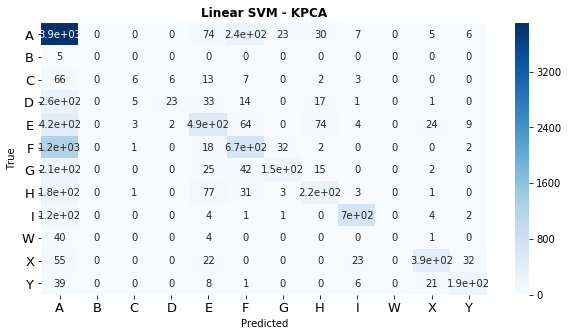

In [0]:
#5-FOLD CROSS VALIDATION WITH LINEAR KERNEL
C_values=[10,100,1000]
tuned_parameters = {'C': C_values,'gamma': ['auto']}
params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_KPCA,Y_train_3)
m_SVM_KPCA, accuracy, precision, recall, f1_score=test(svm.SVC(**params),X_train_KPCA,Y_train_3,X_test_KPCA,Y_test)
plot_confusion_matrix(m_SVM_KPCA, (10,5),'Linear SVM - KPCA')
accuracy_d_kpca['Linear SVM'] = accuracy
precision_d_kpca['Linear SVM'] = precision
recall_d_kpca['Linear SVM'] = recall
f1_score_d_kpca['Linear SVM'] = f1_score

### 3.2.2 Kernel SVM

The kernel adopted for the experiments is the RBF (Radial Basis Function):

<center><p style="text-align: center;">$K(x_i,x_j) = exp(-\gamma\left\lVert x-x'\right\rVert)$</p></center>

So now the hyperparameters to tune are C and gamma.   
Gamma "defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors." (*from scikit-learn official documentation*).

Best parameters set found on the validation set:

{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

Accuracy=0.839
Precision: 0.880
Recall: 0.862
F1-score: 0.871


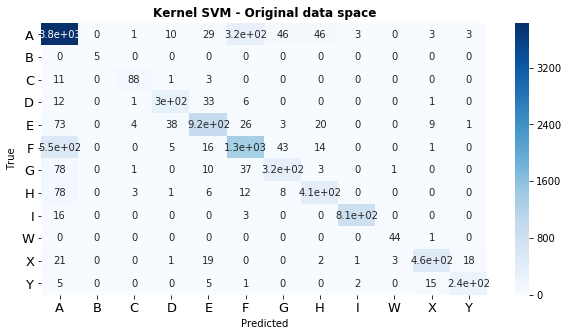

In [0]:
#5-FOLD CROSS VALIDATION WITH RBF KERNEL
C_values=[0.1, 1, 10, 1000]
G_values=[0.1, 1, 10, 1000]

tuned_parameters = {'kernel': ['rbf'], 'gamma': G_values,
                     'C': C_values}
params=FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_3,Y_train_3)
m_SVMK, accuracy, precision, recall, f1_score = test(svm.SVC(**params),X_train_3,Y_train_3,X_test,Y_test)

accuracy_d['Kernel SVM'] = accuracy
precision_d['Kernel SVM'] = precision
recall_d['Kernel SVM'] = recall
f1_score_d['Kernel SVM'] = f1_score
plot_confusion_matrix(m_SVMK, (10,5),'Kernel SVM - Original data space')


Best parameters set found on the validation set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Accuracy=0.623
Precision: 0.644
Recall: 0.480
F1-score: 0.525


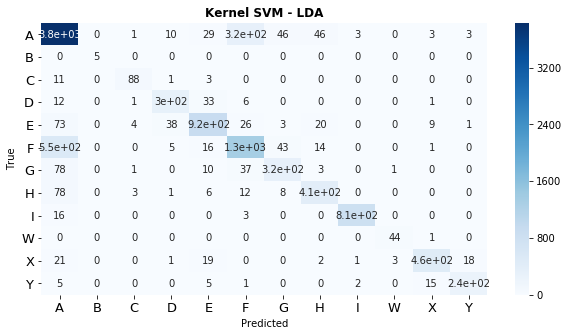

In [0]:
#5-FOLD CROSS VALIDATION WITH RBF KERNEL
C_values=[0.1, 1, 10]
G_values=[0.1, 1, 10]

tuned_parameters = {'kernel': ['rbf'], 'gamma': G_values,
                     'C': C_values}
params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_LDA,Y_train_3)
m_SVMK_LDA,accuracy, precision, recall, f1_score = test(svm.SVC(**params),X_train_LDA,Y_train_3,X_test_LDA,Y_test)
plot_confusion_matrix(m_SVMK, (10,5),'Kernel SVM - LDA')

accuracy_d_lda['Kernel SVM'] = accuracy
precision_d_lda['Kernel SVM'] = precision
recall_d_lda['Kernel SVM'] = recall
f1_score_d_lda['Kernel SVM'] = f1_score

Best parameters set found on the validation set:

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Accuracy=0.815
Precision: 0.800
Recall: 0.705
F1-score: 0.747


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


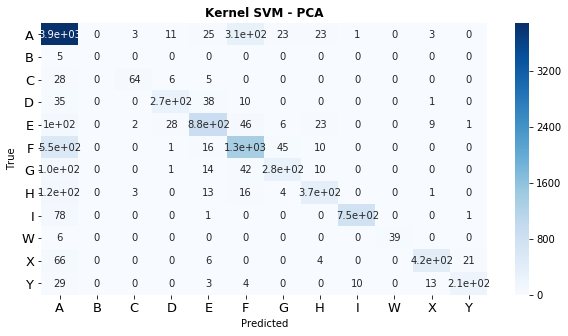

In [0]:
#5-FOLD CROSS VALIDATION WITH RBF KERNEL


C_values=[0.1, 1, 10]
G_values=[0.1, 1, 10]

tuned_parameters = {'kernel': ['rbf'], 'gamma': G_values,
                     'C': C_values}

params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_PCA,Y_train_3)
m_SVMK_PCA,accuracy, precision, recall, f1_score= test(svm.SVC(**params),X_train_PCA,Y_train_3,X_test_PCA,Y_test)
plot_confusion_matrix(m_SVMK_PCA, (10,5),'Kernel SVM - PCA')
accuracy_d_pca['Kernel SVM'] = accuracy
precision_d_pca['Kernel SVM'] = precision
recall_d_pca['Kernel SVM'] = recall
f1_score_d_pca['Kernel SVM'] = f1_score

Best parameters set found on the validation set:

{'C': 10, 'gamma': 10, 'kernel': 'rbf'}

Accuracy=0.704
Precision: 0.658
Recall: 0.541
F1-score: 0.585


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


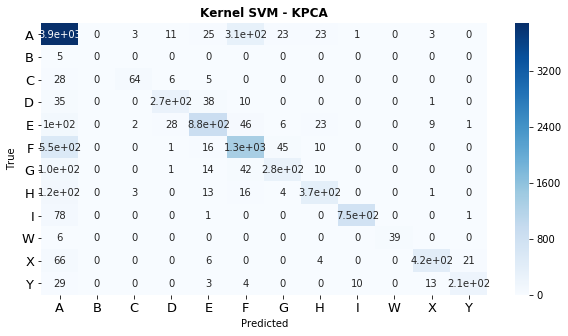

In [0]:
#5-FOLD CROSS VALIDATION WITH RBF KERNEL


C_values=[0.1, 1, 10]
G_values=[0.1, 1, 10]

tuned_parameters = {'kernel': ['rbf'], 'gamma': G_values,
                     'C': C_values}
params= FiveFoldValidation(svm.SVC(),tuned_parameters,X_train_KPCA,Y_train_3)
m_SVMK_KPCA,accuracy, precision, recall, f1_score= test(svm.SVC(**params),X_train_KPCA,Y_train_3,X_test_KPCA,Y_test)
plot_confusion_matrix(m_SVMK_PCA, (10,5),'Kernel SVM - KPCA')
accuracy_d_kpca['Kernel SVM'] = accuracy
precision_d_kpca['Kernel SVM'] = precision
recall_d_kpca['Kernel SVM'] = recall
f1_score_d_kpca['Kernel SVM'] = f1_score

## 3.3 Logistic Regression

Logistic regression can be seen as combination of a linear model and a sigmoid activation function: the linear model provides a regression function that the sigmoid convert in a range [0,1].   
For this reason the application of logistic regression defines the probability that a sample belong to a specific class:

<center><p style="text-align: center;">$P(Y=1|X)= \frac{exp(w_0 +\sum_{i}^n {w_i X_i})}{1+exp(w_0 +\sum_{i}^n {w_i X_i)}}$</p>

<p style="text-align: center;">$P(Y=0|X)= \frac{1}{1+exp(w_0 +\sum_{i}^n {w_i X_i)}}$</p></center>

where $w_0 +\sum_{i}^n {w_i X_i}$ represent the linear decision boundary.

For a multiclass problem, the training algorithm uses the OvR (one-vs-rest approach).



/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Misclassified samples: 4887
Accuracy: 0.53
Precision: 0.42245642406296396
Recall: 0.35131169979814403
F1-score: 0.35082997564454793


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


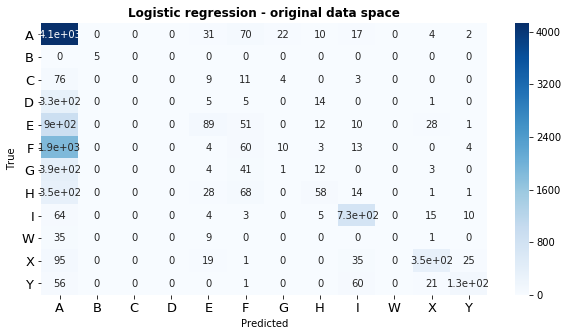

In [0]:
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_train_3, Y_train_3.values.ravel())

# use the model to make predictions with the test data
Y_pred = log_reg.predict(X_test)

# how did our model perform?
count_misclassified = (Y_test.values.ravel() != Y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_pred, average='macro')
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {f1_score}")

accuracy_d['Logistic regression'] = accuracy
precision_d['Logistic regression'] = precision
recall_d['Logistic regression'] = recall
f1_score_d['Logistic regression'] = f1_score
m_log = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(m_log, (10,5),'Logistic regression - original data space')

/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Misclassified samples: 5106
Accuracy: 0.51


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


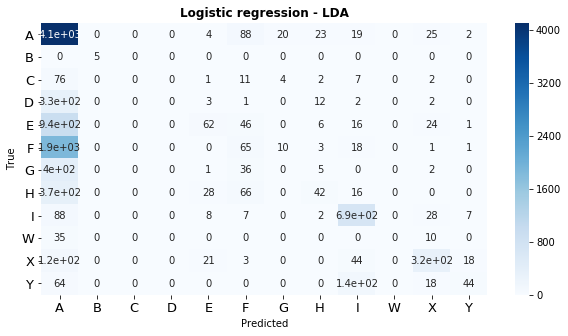

In [0]:
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_train_LDA, Y_train_3.values.ravel())

# use the model to make predictions with the test data
Y_pred = log_reg.predict(X_test_LDA)
# how did our model perform?
count_misclassified = (Y_test.values.ravel() != Y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
m_log_LDA = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(m_log_LDA, (10,5),'Logistic regression - LDA')

precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_pred, average='macro')
accuracy_d_lda['Logistic regression'] = accuracy
precision_d_lda['Logistic regression'] = precision
recall_d_lda['Logistic regression'] = recall
f1_score_d_lda['Logistic regression'] = f1_score

/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Misclassified samples: 4890
Accuracy: 0.53


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


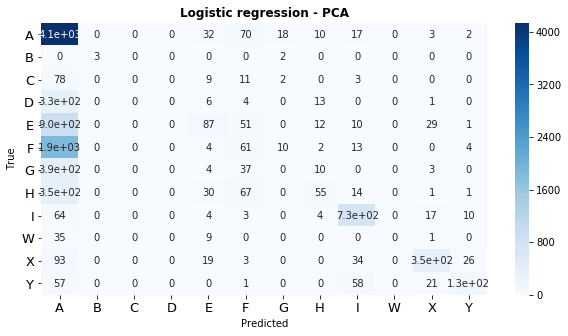

In [0]:
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_train_PCA, Y_train_3.values.ravel())

# use the model to make predictions with the test data
Y_pred = log_reg.predict(X_test_PCA)
# how did our model perform?
count_misclassified = (Y_test.values.ravel() != Y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
m_log_PCA = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(m_log_PCA, (10,5),'Logistic regression - PCA')
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_pred, average='macro')
accuracy_d_pca['Logistic regression'] = accuracy
precision_d_pca['Logistic regression'] = precision
recall_d_pca['Logistic regression'] = recall
f1_score_d_pca['Logistic regression'] = f1_score

/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Misclassified samples: 4661
Accuracy: 0.55


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


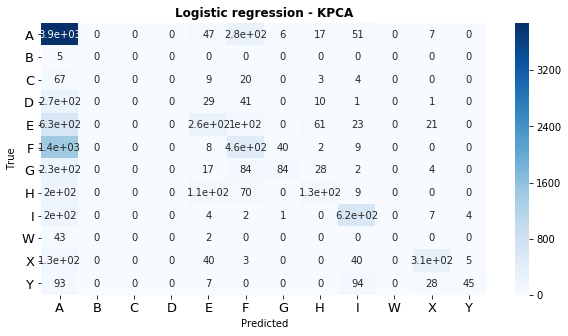

In [0]:
log_reg = LogisticRegression(solver = 'lbfgs')
log_reg.fit(X_train_KPCA, Y_train_3.values.ravel())

# use the model to make predictions with the test data
Y_pred = log_reg.predict(X_test_KPCA)
# how did our model perform?
count_misclassified = (Y_test.values.ravel() != Y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(Y_test, Y_pred)
print('Accuracy: {:.2f}'.format(accuracy))
m_log_KPCA = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(m_log_KPCA, (10,5),'Logistic regression - KPCA')
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_pred, average='macro')
accuracy_d_kpca['Logistic regression'] = accuracy
precision_d_kpca['Logistic regression'] = precision
recall_d_kpca['Logistic regression'] = recall
f1_score_d_kpca['Logistic regression'] = f1_score

As for the previous techniques, different logistic regression models are fitted for data in the 4 different representations; however performance are not so good for all as it reaches values around 55%.

## 3.4  K-Neighbors

K-neighbors is a non parametric classification techniques based on data density estimation from the labeled data, more specifically on the estimation of the posterior distribution $p(c_i|x)$, i.e. the probability that a given sample *x* belong to a class *c*.       
Given a similarity metric, generally euclidean distance, kNN is based on the assumption that similar points belong to the same class: the algorithm consists in assigning to a new sample the most frequent label among the K nearest neighbors.     
The value of K strongly impacts on kNN performance.   

Again a 5-fold cross validation is adopted to choose the best value of K for the given training data and the euclidean distance is assumed as good.   

Best parameters set found on the validation set:

{'metric': 'euclidean', 'n_neighbors': 1}

Accuracy=0.758
Precision: 0.782
Recall: 0.748
F1-score: 0.763


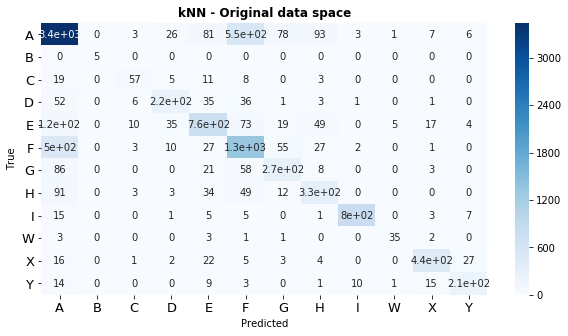

In [0]:
#5-FOLD CROSS VALIDATION WITH LINEAR KERNEL
K_values=[5,7,1,3]
tuned_parameters = {'n_neighbors': K_values, 'metric' : ['euclidean']}
params= FiveFoldValidation(KNeighborsClassifier(),tuned_parameters,X_train_3,Y_train_3)
m_knn, accuracy, precision, recall, f1_score = test(KNeighborsClassifier(**params),X_train_3,Y_train_3,X_test,Y_test)

accuracy_d['kNN'] = accuracy
precision_d['kNN'] = precision
recall_d['kNN'] = recall
f1_score_d['kNN'] = f1_score

plot_confusion_matrix(m_knn, (10,5),'kNN - Original data space')

Best parameters set found on the validation set:

{'metric': 'euclidean', 'n_neighbors': 13}

Accuracy=0.606
Precision: 0.499
Recall: 0.380
F1-score: 0.403


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


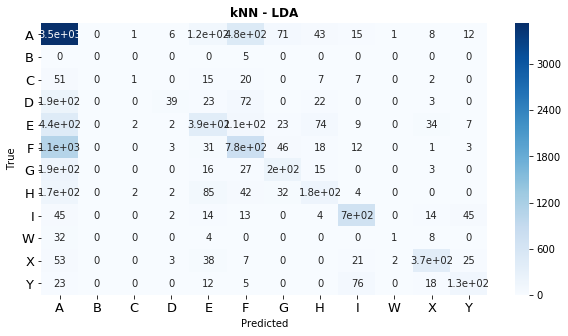

In [0]:
K_values=[3,7,9,13,15]
tuned_parameters = {'n_neighbors': K_values, 'metric' : ['euclidean']}
params= FiveFoldValidation(KNeighborsClassifier(),tuned_parameters,X_train_LDA,Y_train_3)
m_knn_LDA, accuracy, precision, recall, f1_score =test(KNeighborsClassifier(**params),X_train_LDA,Y_train_3,X_test_LDA,Y_test)


plot_confusion_matrix(m_knn_LDA, (10,5),'kNN - LDA')
accuracy_d_lda['kNN'] = accuracy
precision_d_lda['kNN'] = precision
recall_d_lda['kNN'] = recall
f1_score_d_lda['kNN'] = f1_score

Best parameters set found on the validation set:

{'metric': 'euclidean', 'n_neighbors': 1}

Accuracy=0.757
Precision: 0.777
Recall: 0.745
F1-score: 0.760


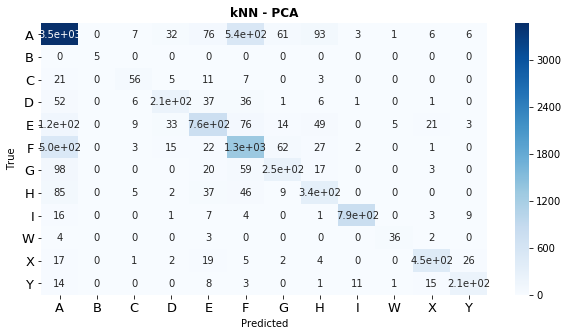

In [0]:
K_values=[5,7,1,3]
tuned_parameters = {'n_neighbors': K_values, 'metric' : ['euclidean']}

params= FiveFoldValidation(KNeighborsClassifier(),tuned_parameters,X_train_PCA,Y_train_3)
m_knn_PCA, accuracy, precision, recall, f1_score =test(KNeighborsClassifier(**params),X_train_PCA,Y_train_3,X_test_PCA,Y_test)

plot_confusion_matrix(m_knn_PCA, (10,5),'kNN - PCA')
accuracy_d_pca['kNN'] = accuracy
precision_d_pca['kNN'] = precision
recall_d_pca['kNN'] = recall
f1_score_d_pca['kNN'] = f1_score

Best parameters set found on the validation set:

{'metric': 'euclidean', 'n_neighbors': 3}

Accuracy=0.663
Precision: 0.623
Recall: 0.532
F1-score: 0.564


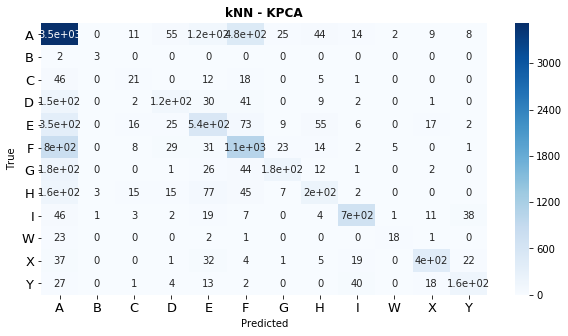

In [0]:
K_values=[5,7,1,3]
tuned_parameters = {'n_neighbors': K_values, 'metric' : ['euclidean']}
params= FiveFoldValidation(KNeighborsClassifier(),tuned_parameters,X_train_KPCA,Y_train_3)
m_knn_KPCA,accuracy, precision, recall, f1_score =test(KNeighborsClassifier(**params),X_train_KPCA,Y_train_3,X_test_KPCA,Y_test)

plot_confusion_matrix(m_knn_KPCA, (10,5),'kNN - KPCA')
accuracy_d_kpca['kNN'] = accuracy
precision_d_kpca['kNN'] = precision
recall_d_kpca['kNN'] = recall
f1_score_d_kpca['kNN'] = f1_score

For the data in the original space and for the projections on the PCA components the best performing K is 1: the label of a new sample *x* is determined by the nearest neighbors according to the Euclidean distance.   
Remember that kNN is high sensitive to outliers: having a K=1 means high variability on the training data, as minimum changes on it can significantly disrupt the decision boundaries.    
For data projections on the Kernel PCA components, the model with K=3 outperforms the other K values but with an accuracy not too high with respcet to the original space and PCA one.   
The model fitted on the data projected in the PCA space have pretty the same performance as the one on the data in the original space but with a higher K.   


## 3.5 Decision Tree

The Decision Trees are a non parametric supervised techniques used for classification and regression, succesfully especially for complex classification problems.  
They are based on the development of a decision tree built incrementally according to a top-down greedy approach: the dataset is splitted in smaller subsets according to some decision criteria represented by the intermediate node (*decision node*).    
Each decision node has two or more branches and the leaf node (the terminal ones) represent the result of the decision/classification.
Each decision node represents the best decision criterion on the subset of the dataset on which it is applied, chosen as the one maximizing the purity of the splits generated from the decision criterion; the top one is the best predictor on the whole dataset and it is called root node.    

Generally decision trees are characterized by high adaptability and computational effectiveness and they are not based on any distribution assumption on the input data. Moreover the tree-structure is high interpretable with respect to other classification methods.    

Even if it is a non parametric approach, in this experiment tuning was performed to set the criterion, the max depth and the minimum sample leaf:    

* criterion: the function to measure the quality of a split. During the decision tree development the criterion chosen as the next decision node is the one associated with the lowest gini impurity on the split or with the highest information gain: 'gini' and 'entropy' are the two criteria evaluated during the validatio:   

<center><p style="text-align: center;">$Gini= \sum_{k=1}^K{p_mk(1-p_mk)}$</p>


<p style="text-align: center;">$Entropy= \sum_{k=1}^K{p_mklog(p_mk)}$</p></center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where *p<sub>mk</sub>* represents the proportion of data in the m-th split belonging to the k-th class.




* max depth: generally the decision trees can grows until all leaves are pure, i.e. they contains samples of the same class or contains less thain a fixed number of samples; however let the model become even more specific is not a good idea for overfitting issues and for general complexity of the model: to avoid this the *max_depth<* parameter can be tuned to set the optimal growth limit for the actual data.
* min_samples_leaf: The minimum number of samples required to be at a leaf node. 


Best parameters set found on the validation set:

{'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 3}

Accuracy=0.980
Precision: 0.955
Recall: 0.932
F1-score: 0.938


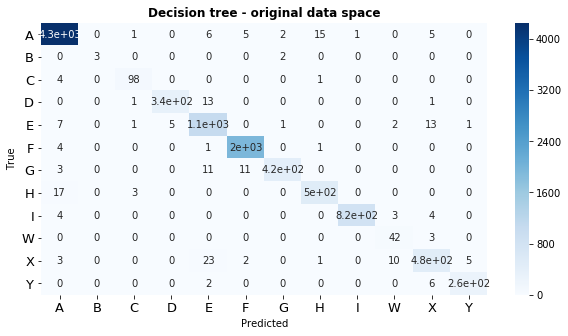

In [0]:
tuned_parameters = {'criterion': ['gini','entropy'],'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'min_samples_leaf':[3,4,5]}

params= FiveFoldValidation(DecisionTreeClassifier(),tuned_parameters,X_train_3,Y_train_3)
m_dt,accuracy, precision, recall, f1_score = test(DecisionTreeClassifier(**params),X_train_3,Y_train_3,X_test,Y_test)

accuracy_d['Decision Tree'] = accuracy
precision_d['Decision Tree'] = precision
recall_d['Decision Tree'] = recall
f1_score_d['Decision Tree'] = f1_score


plot_confusion_matrix(m_dt, (10,5),'Decision tree - original data space')

Best parameters set found on the validation set:

{'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 5}

Accuracy=0.574
Precision: 0.505
Recall: 0.444
F1-score: 0.462


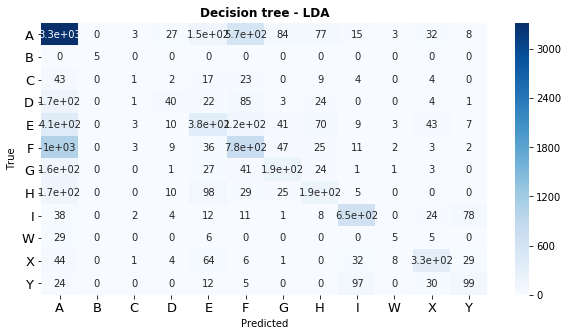

In [0]:
tuned_parameters = {'criterion': ['gini','entropy'], 'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'min_samples_leaf':[3,4,5]}

params= FiveFoldValidation(DecisionTreeClassifier(),tuned_parameters,X_train_LDA,Y_train_3)
m_dt_LDA, accuracy, precision, recall, f1_score = test(DecisionTreeClassifier(**params),X_train_LDA,Y_train_3,X_test_LDA,Y_test)

plot_confusion_matrix(m_dt_LDA, (10,5),'Decision tree - LDA')
accuracy_d_lda['Decision Tree'] = accuracy
precision_d_lda['Decision Tree'] = precision
recall_d_lda['Decision Tree'] = recall
f1_score_d_lda['Decision Tree'] = f1_score

Best parameters set found on the validation set:

{'criterion': 'gini', 'max_depth': 14, 'min_samples_leaf': 3}

Accuracy=0.624
Precision: 0.572
Recall: 0.534
F1-score: 0.541


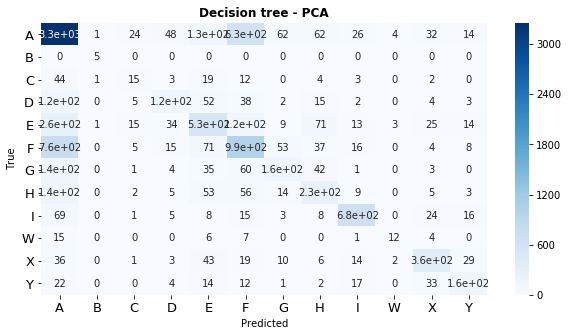

In [0]:
tuned_parameters = {'criterion': ['gini','entropy'], 'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'min_samples_leaf':[3,4,5]}

params= FiveFoldValidation(DecisionTreeClassifier(),tuned_parameters,X_train_PCA,Y_train_3)
m_dt_PCA, accuracy, precision, recall, f1_score = test(DecisionTreeClassifier(**params),X_train_PCA,Y_train_3,X_test_PCA,Y_test)

plot_confusion_matrix(m_dt_PCA, (10,5),'Decision tree - PCA')
accuracy_d_pca['Decision Tree'] = accuracy
precision_d_pca['Decision Tree'] = precision
recall_d_pca['Decision Tree'] = recall
f1_score_d_pca['Decision Tree'] = f1_score

Best parameters set found on the validation set:

{'criterion': 'entropy', 'max_depth': 12, 'min_samples_leaf': 5}

Accuracy=0.582
Precision: 0.474
Recall: 0.378
F1-score: 0.408


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


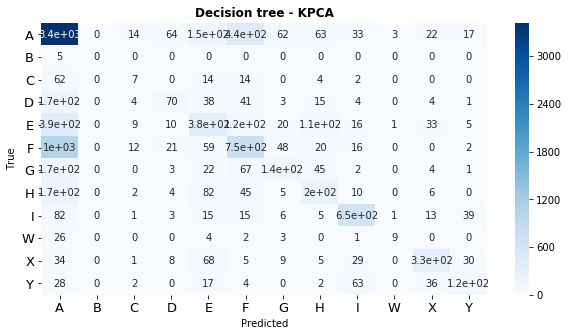

In [0]:
tuned_parameters = {'criterion': ['gini','entropy'], 'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 'min_samples_leaf':[3,4,5]}

params= FiveFoldValidation(DecisionTreeClassifier(),tuned_parameters,X_train_KPCA,Y_train_3)
m_dt_KPCA, accuracy, precision, recall, f1_score = test(DecisionTreeClassifier(**params),X_train_KPCA,Y_train_3,X_test_KPCA,Y_test)

plot_confusion_matrix(m_dt_KPCA, (10,5),'Decision tree - KPCA')
accuracy_d_kpca['Decision Tree'] = accuracy
precision_d_kpca['Decision Tree'] = precision
recall_d_kpca['Decision Tree'] = recall
f1_score_d_kpca['Decision Tree'] = f1_score

As expected on the complex problems, the decision tree model performs very well on the data in the original space reaching accuracy equal to 98%.    
However the performance are altered when data are projected in PCA and LDA spaces where the accuracy doesn't overcome 65%.   

## 3.6 Random Forest

The main idea behind the random forest is taking decision according to a batch of decision tree rather than only one.   
At training time each decision tree of the random forest is built starting from a subset of original features and on a subset of training data: this allows to have diversity in the different decision tree and prevent from co-adaptation of features.   
At test time each decision tree performs his prediction for a new sample *x* and the final prediction of the overall model results from the average of the decision trees composing the random forest.    

This approach loses the interpretability of the single decision tree and it's more computationally expensive both at training and classification time, but it provides more robust classification and more reliable estimate of feature importanc as well as a generally more accurate model with respect to the decision tree that are highly affected by variance.   



Best parameters set found on the validation set:

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}

Accuracy=0.985
Precision: 0.990
Recall: 0.979
F1-score: 0.985


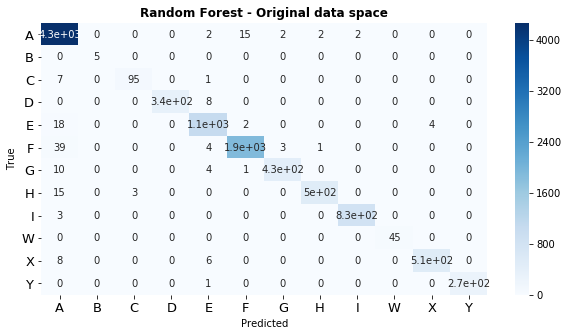

In [0]:
n = [100,400,600,800]
tuned_parameters = {'n_estimators':n, 'bootstrap' : [True], 'max_features' : ['sqrt']}

params= FiveFoldValidation(RandomForestClassifier(),tuned_parameters,X_train_3,Y_train_3)
m_rf, accuracy, precision, recall, f1_score = test(RandomForestClassifier(**params),X_train_3,Y_train_3,X_test,Y_test)

accuracy_d['Random Forest'] = accuracy
precision_d['Random Forest'] = precision
recall_d['Random Forest'] = recall
f1_score_d['Random Forest'] = f1_score

plot_confusion_matrix(m_rf, (10,5),'Random Forest - Original data space')
  

Best parameters set found on the validation set:

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}

Accuracy=0.615
Precision: 0.610
Recall: 0.489
F1-score: 0.516


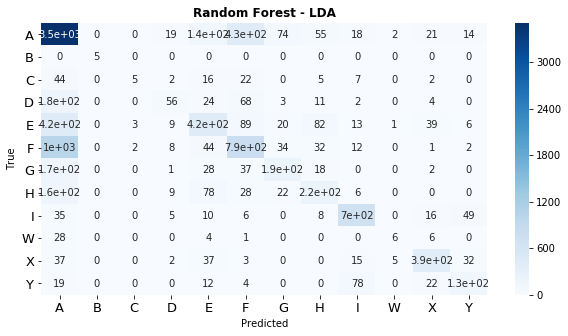

In [0]:
n = [100,400,600]
tuned_parameters = {'n_estimators':n, 'bootstrap' : [True], 'max_features' : ['sqrt']}

params= FiveFoldValidation(RandomForestClassifier(),tuned_parameters,X_train_LDA,Y_train_3)
m_rf_LDA, accuracy, precision, recall, f1_score = test(RandomForestClassifier(**params),X_train_LDA,Y_train_3,X_test_LDA,Y_test)

plot_confusion_matrix(m_rf_LDA, (10,5),'Random Forest - LDA')

accuracy_d_lda['Random Forest'] = accuracy
precision_d_lda['Random Forest'] = precision
recall_d_lda['Random Forest'] = recall
f1_score_d_lda['Random Forest'] = f1_score
  

Best parameters set found on the validation set:

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 400}

Accuracy=0.742
Precision: 0.843
Recall: 0.622
F1-score: 0.680


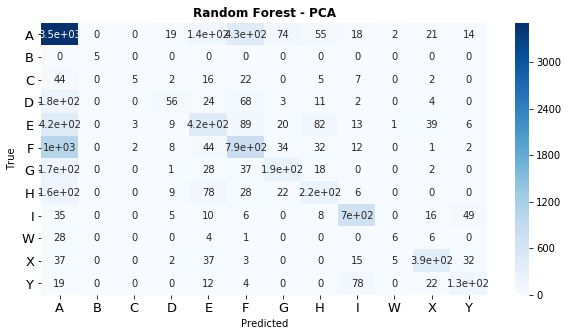

In [0]:
n = [100,400,600,800]
tuned_parameters = {'n_estimators':n, 'bootstrap' : [True], 'max_features' : ['sqrt']}

params= FiveFoldValidation(RandomForestClassifier(),tuned_parameters,X_train_PCA,Y_train_3)
m_rf_PCA, accuracy, precision, recall, f1_score = test(RandomForestClassifier(**params),X_train_PCA,Y_train_3,X_test_PCA,Y_test)

plot_confusion_matrix(m_rf_LDA, (10,5),'Random Forest - PCA')
  
accuracy_d_pca['Random Forest'] = accuracy
precision_d_pca['Random Forest'] = precision
recall_d_pca['Random Forest'] = recall
f1_score_d_pca['Random Forest'] = f1_score


Best parameters set found on the validation set:

{'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 600}

Accuracy=0.680
Precision: 0.678
Recall: 0.483
F1-score: 0.533


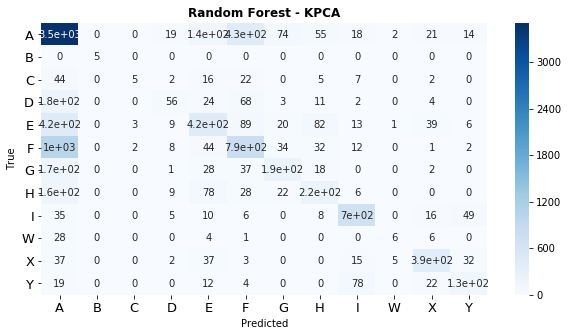

In [0]:
n = [100,400,600,800]
tuned_parameters = {'n_estimators':n, 'bootstrap' : [True], 'max_features' : ['sqrt']}

params= FiveFoldValidation(RandomForestClassifier(),tuned_parameters,X_train_KPCA,Y_train_3)
m_rf_KPCA, accuracy, precision, recall, f1_score = test(RandomForestClassifier(**params),X_train_KPCA,Y_train_3,X_test_KPCA,Y_test)

plot_confusion_matrix(m_rf_LDA, (10,5),'Random Forest - KPCA')

accuracy_d_kpca['Random Forest'] = accuracy
precision_d_kpca['Random Forest'] = precision
recall_d_kpca['Random Forest'] = recall
f1_score_d_kpca['Random Forest'] = f1_score
  

As expected the accuracy values are higher with respect to the decision tree and for data represented in the original space the best model reaches 98% of accuracy.    

## 3.7 Gaussian Naive Bayes Classifier

The Gaussian Naive Bayes Classifier is a supervised generative technique according to which the classification task is addressed through probability estimation: given a new sample *x* the probability of belonging to class Y P(Y|X) is estimated, according to Bayes Rule, starting from a class prior P(Y) and from the likelihood of observed data P(X|Y).   
In order to easy perform such computation NB classifier makes some simplicistic assumptions:  

* the features characterizing X are i.i.d. in a given class, so $P(X|Y) = P(Y)\prod\limits_{i=1}^d {P(x_i|Y)}$; 
* in the case of Gaussian NV classifier, a parametric gaussian shape is assumed for P(x|Y) and a bernoulli one for P(Y);   

Pratically the logistic regression and the gaussian NB classifier both perform the same task, i.e. learn a linear decision boundary, but with different approaches and based on different assumptions.   

On infinite data, it can be demonstrated that discriminative approach, like logistic regression, outperforms GNB classifier but for finite data, if the feature independence assumption holds, it converge slower than it.

Accuracy=0.3342
Precision: 0.3905210280395252
Recall: 0.4664836128062259
F1-score: 0.3817759099919833


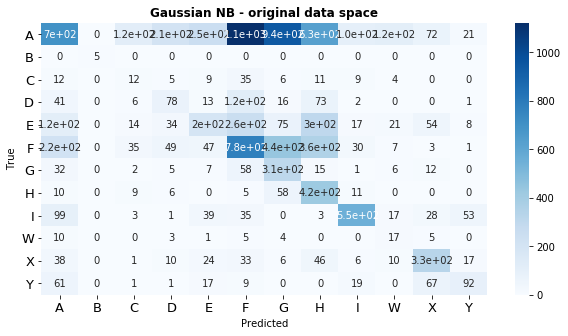

In [0]:
g_NB = GaussianNB()
g_NB.fit(X_train_3, Y_train_3.values.ravel())
#Evaluation of the accuracy on the test_set
Y_test_pred=g_NB.predict(X_test)
accuracy = accuracy_score(Y_test,Y_test_pred)
print('Accuracy=%.4f'%(accuracy))

precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_test_pred, average='macro')
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {f1_score}")

accuracy_d['GNB'] = accuracy
precision_d['GNB'] = precision
recall_d['GNB'] = recall
f1_score_d['GNB'] = f1_score

m_GNB = confusion_matrix(Y_test, Y_test_pred)
plot_confusion_matrix(m_GNB, (10,5),'Gaussian NB - original data space')

Accuracy=0.5240


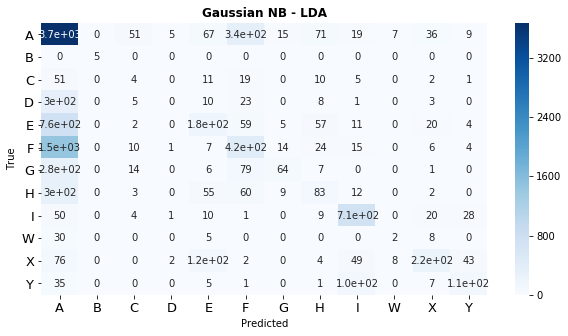

In [0]:
g_NB = GaussianNB()
g_NB.fit(X_train_LDA, Y_train_3.values.ravel())
#Evaluation of the accuracy on the test_set
Y_test_pred=g_NB.predict(X_test_LDA)
accuracy = accuracy_score(Y_test,Y_test_pred)
print('Accuracy=%.4f'%(accuracy))

m_GNB_LDA = confusion_matrix(Y_test, Y_test_pred)
plot_confusion_matrix(m_GNB_LDA, (10,5),'Gaussian NB - LDA')
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_test_pred, average='macro')

accuracy_d_lda['GNB'] = accuracy
precision_d_lda['GNB'] = precision
recall_d_lda['GNB'] = recall
f1_score_d_lda['GNB'] = f1_score

Accuracy=0.3892


/Users/giuseppe.pastore/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


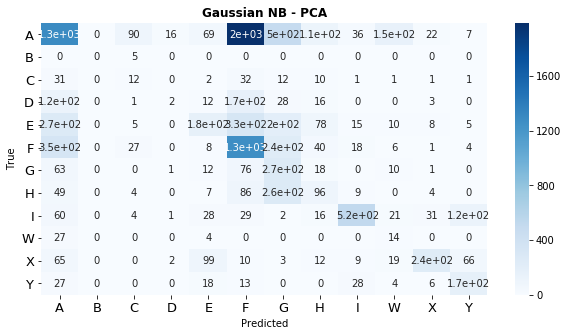

In [0]:
g_NB = GaussianNB()
g_NB.fit(X_train_PCA, Y_train_3.values.ravel())
#Evaluation of the accuracy on the test_set
Y_test_pred=g_NB.predict(X_test_PCA)
accuracy = accuracy_score(Y_test,Y_test_pred)
print('Accuracy=%.4f'%(accuracy))

m_GNB_PCA = confusion_matrix(Y_test, Y_test_pred)
plot_confusion_matrix(m_GNB_PCA, (10,5),'Gaussian NB - PCA')
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_test_pred, average='macro')
accuracy_d_pca['GNB'] = accuracy
precision_d_pca['GNB'] = precision
recall_d_pca['GNB'] = recall
f1_score_d_pca['GNB'] = f1_score

Accuracy=0.5200


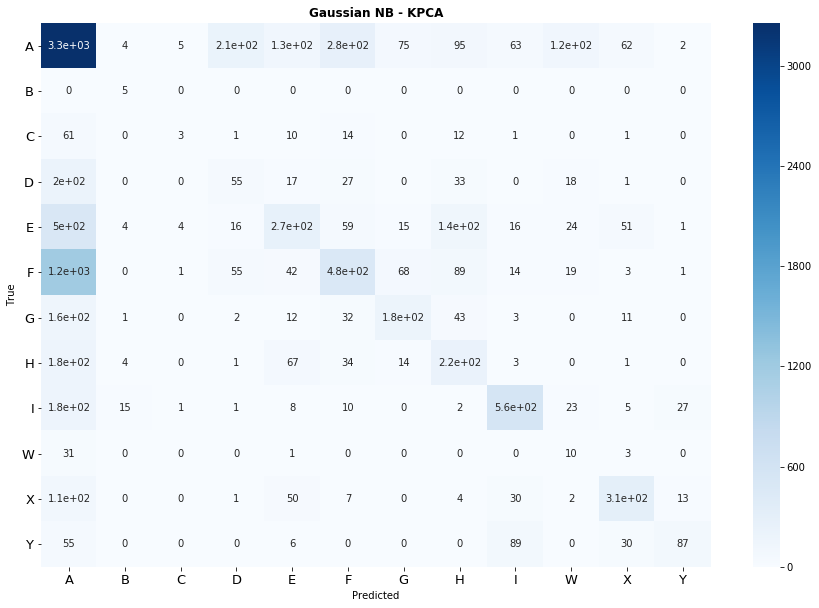

In [0]:
g_NB = GaussianNB()
g_NB.fit(X_train_KPCA, Y_train_3.values.ravel())
#Evaluation of the accuracy on the test_set
Y_test_pred=g_NB.predict(X_test_KPCA)
accuracy = accuracy_score(Y_test,Y_test_pred)
print('Accuracy=%.4f'%(accuracy))


m_GNB_KPCA = confusion_matrix(Y_test, Y_test_pred)
plot_confusion_matrix(m_GNB_KPCA, (15,10),'Gaussian NB - KPCA')
precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_test_pred, average='macro')
accuracy_d_kpca['GNB'] = accuracy
precision_d_kpca['GNB'] = precision
recall_d_kpca['GNB'] = recall
f1_score_d_kpca['GNB'] = f1_score

## 3.8 LDA as classification

Accuracy: 0.510874772444189
Precision: 0.4133902877007562
Recall: 0.42229261629430787
F1-score: 0.36760874959878875


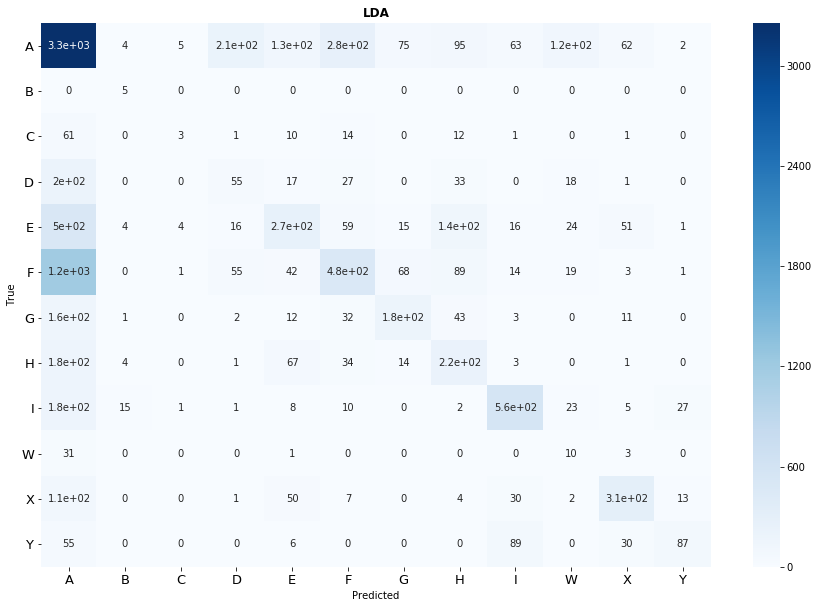

In [0]:
# %% Data extracted; perform LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_3,Y_train_3.values.ravel())
accuracy = lda.score(X_test, Y_test.values.ravel())
print('Accuracy: ' + str(accuracy))

precision, recall, f1_score, _ = metrics.precision_recall_fscore_support(Y_test, Y_test_pred, average='macro')
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {f1_score}")

accuracy_d['LDA'] = accuracy
precision_d['LDA'] = precision
recall_d['LDA'] = recall
f1_score_d['LDA'] = f1_score
m_LDA = confusion_matrix(Y_test, Y_test_pred)
plot_confusion_matrix(m_LDA, (15,10),'LDA')


# 4 Conclusion 

In [0]:
def display_sum(acc,pre,rec,f1):
    print ('\t\tMethod\t\t|\tAccuracy\t|\tPrecision\t|\tRecall\t|\tF1_score')
    print ('------------------------------------------------------------------------------------------------------------------')
    for key in acc.keys():
        print ("%20s\t\t|\t%.3f\t\t|\t%.3f\t\t|\t%.3f\t|\t%.3f"%(key, acc[key], pre[key],rec[key],f1[key]))


The tables below summarize the results obtained applying the proposed classification methods, fitting the model on the cleaned training set and evaluating it on the provided test set. In the cases of PCA, Kernel PCA and LDA, test data are projected in the same space of the training one before performing the prediction.   Note that LDA is included only in the table related to the classification task performed on data in the original data space.

#### Original data space

In [0]:
display_sum(accuracy_d,precision_d,recall_d,f1_score_d)

		Method		|	Accuracy	|	Precision	|	Recall	|	F1_score
------------------------------------------------------------------------------------------------------------------
          Linear SVM		|	0.839		|	0.880		|	0.862	|	0.871
          Kernel SVM		|	0.839		|	0.880		|	0.862	|	0.871
 Logistic regression		|	0.532		|	0.422		|	0.351	|	0.351
                 kNN		|	0.758		|	0.782		|	0.748	|	0.763
       Decision Tree		|	0.980		|	0.955		|	0.932	|	0.938
       Random Forest		|	0.985		|	0.990		|	0.979	|	0.985
                 GNB		|	0.334		|	0.391		|	0.466	|	0.382
                 LDA		|	0.511		|	0.413		|	0.422	|	0.368


The tables below summarize the results obtained applying the proposed classification methods, fitting the model on the cleaned training set and evaluating it on the provided test set. In the cases of PCA, Kernel PCA and LDA, test data are projected in the same space of the training one before performing the prediction.   
Note that LDA is included only in the table related to the classification task performed on data in the original data space.

#### Data projected along the 4 most signficative LDA components

In [0]:
display_sum(accuracy_d_lda,precision_d_lda,recall_d_lda,f1_score_d_lda)

		Method		|	Accuracy	|	Precision	|	Recall	|	F1_score
------------------------------------------------------------------------------------------------------------------
          Linear SVM		|	0.622		|	0.634		|	0.487	|	0.523
          Kernel SVM		|	0.623		|	0.644		|	0.480	|	0.525
 Logistic regression		|	0.511		|	0.390		|	0.311	|	0.303
                 kNN		|	0.606		|	0.499		|	0.380	|	0.403
       Decision Tree		|	0.574		|	0.505		|	0.444	|	0.462
       Random Forest		|	0.615		|	0.610		|	0.489	|	0.516
                 GNB		|	0.524		|	0.449		|	0.360	|	0.376


Along the 4 LDA components, contrarily to what was expected, the performance evaluated are generally lower with respect to the original data space: only the logistic regression reach performance comparable to the ones in the original data space but however not very good.   
The GNB performance are improved with this data representation but however they are not very high.

#### Data projected along the linear PCA components

In [0]:
display_sum(accuracy_d_pca,precision_d_pca,recall_d_pca,f1_score_d_pca)

		Method		|	Accuracy	|	Precision	|	Recall	|	F1_score
------------------------------------------------------------------------------------------------------------------
          Linear SVM		|	0.823		|	0.873		|	0.785	|	0.816
          Kernel SVM		|	0.815		|	0.800		|	0.705	|	0.747
 Logistic regression		|	0.531		|	0.420		|	0.317	|	0.329
                 kNN		|	0.757		|	0.777		|	0.745	|	0.760
       Decision Tree		|	0.624		|	0.572		|	0.534	|	0.541
       Random Forest		|	0.742		|	0.843		|	0.622	|	0.680
                 GNB		|	0.389		|	0.330		|	0.337	|	0.296


Along the PCA components, without dimensionality reduction, the performance are pretty the same of the original data space, apart for the decision tree and the random forest that are badly affected by the change of basis. 

#### Data projected along the kernel PCA components

In [0]:
display_sum(accuracy_d_kpca,precision_d_kpca,recall_d_kpca,f1_score_d_kpca)

		Method		|	Accuracy	|	Precision	|	Recall	|	F1_score
------------------------------------------------------------------------------------------------------------------
          Linear SVM		|	0.647		|	0.576		|	0.408	|	0.443
          Kernel SVM		|	0.704		|	0.658		|	0.541	|	0.585
 Logistic regression		|	0.553		|	0.416		|	0.276	|	0.302
                 kNN		|	0.663		|	0.623		|	0.532	|	0.564
       Decision Tree		|	0.582		|	0.474		|	0.378	|	0.408
       Random Forest		|	0.680		|	0.678		|	0.483	|	0.533
                 GNB		|	0.520		|	0.413		|	0.422	|	0.368


Again this data representation doens't provide any particoular advantage for the classificatgion task as generally the performance decreases or remain the same. 

All in all the ten features characterizing the original data seems to offer already a good representation of data from the point of view of the classification task. 